In [1]:
!export CUDA_VISIBLE_DEVICES=3

In [3]:
!pip install tslearn

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 MB 97.4 MB/s eta 0:00:00:00:0100:01


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.fft as fft
import pickle
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tslearn.metrics import dtw
from scipy.signal import find_peaks

/home/quyi/.local/lib/python3.9/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
os.getcwd()

'/home/quyi/temple_hpc_transf/PPG2ECG'

In [3]:
csv_lst = []
for f in os.listdir(os.getcwd() + '/bidmc_csv'):
    if f[-11:] == 'Signals.csv' and f[0] != '.':
        csv_lst.append(f)
        print(f)

bidmc_27_Signals.csv
bidmc_11_Signals.csv
bidmc_52_Signals.csv
bidmc_07_Signals.csv
bidmc_28_Signals.csv
bidmc_04_Signals.csv
bidmc_06_Signals.csv
bidmc_39_Signals.csv
bidmc_26_Signals.csv
bidmc_22_Signals.csv
bidmc_53_Signals.csv
bidmc_01_Signals.csv
bidmc_36_Signals.csv
bidmc_44_Signals.csv
bidmc_29_Signals.csv
bidmc_51_Signals.csv
bidmc_08_Signals.csv
bidmc_33_Signals.csv
bidmc_02_Signals.csv
bidmc_17_Signals.csv
bidmc_46_Signals.csv
bidmc_43_Signals.csv
bidmc_32_Signals.csv
bidmc_24_Signals.csv
bidmc_31_Signals.csv
bidmc_25_Signals.csv
bidmc_12_Signals.csv
bidmc_18_Signals.csv
bidmc_20_Signals.csv
bidmc_30_Signals.csv
bidmc_13_Signals.csv
bidmc_35_Signals.csv
bidmc_50_Signals.csv
bidmc_16_Signals.csv
bidmc_23_Signals.csv
bidmc_48_Signals.csv
bidmc_49_Signals.csv
bidmc_15_Signals.csv
bidmc_10_Signals.csv
bidmc_47_Signals.csv
bidmc_34_Signals.csv
bidmc_14_Signals.csv
bidmc_45_Signals.csv
bidmc_41_Signals.csv
bidmc_09_Signals.csv
bidmc_03_Signals.csv
bidmc_42_Signals.csv
bidmc_05_Sign

In [4]:
df = pd.read_csv('./bidmc_csv/'+csv_lst[0])

In [5]:
df

Time [s]     RESP       II        V       AVR    PLETH
0         0.000 -0.11262  0.80000  0.74118  0.025391  0.65396
1         0.008 -0.11068  0.80000  0.73529  0.015625  0.68231
2         0.016 -0.10680  0.81569  0.74118  0.000000  0.70479
3         0.024 -0.10291  0.82157  0.70588 -0.003906  0.72239
4         0.032 -0.10097  0.77647  0.68039  0.009766  0.73412
...         ...      ...      ...      ...       ...      ...
59996   479.970  0.45243  1.02160  0.98235 -0.074219  0.20430
59997   479.980  0.45243  1.03140  0.99608 -0.070312  0.20528
59998   479.980  0.45049  1.06670  1.01180 -0.093750  0.21310
59999   479.990  0.45049  1.10200  1.02160 -0.109380  0.22581
60000   480.000  0.44854  1.11180  1.01570 -0.125000  0.24438

[60001 rows x 6 columns]

In [6]:
ECG = df[' II']
PPG = df[' PLETH']
print(ECG.shape)

(60001,)


In [7]:
df = pd.read_csv('./bidmc_csv/'+csv_lst[0])
ECG = df[' II']
PPG = df[' PLETH']
stander = StandardScaler()
scaler = MinMaxScaler(feature_range=(-1, 1))
ECG = scaler.fit_transform(stander.fit_transform(ECG.to_numpy().reshape(-1, 1))).squeeze()
PPG = scaler.fit_transform(stander.fit_transform(PPG.to_numpy().reshape(-1, 1))).squeeze()
print(ECG.shape)

(60001,)


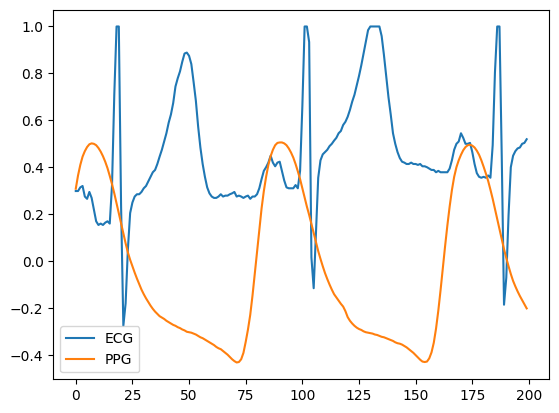

In [8]:
import matplotlib.pyplot as plt

ra = np.fft.fft(PPG[:200]).real
im = np.fft.fft(PPG[:200]).imag
sq = np.sqrt(ra ** 2 + im ** 2)
# fq = np.fft.fftfreq(PPG[:200])

plt.plot(ECG[:200], label="ECG")
plt.plot(PPG[:200], label="PPG")
# plt.plot(np.fft.fft(PPG[:200]).real, label="PPG real")
# plt.plot(np.fft.fft(PPG[:200]).imag, label="PPG imag")
# plt.plot(sq, label="PPG sqrt")
# plt.plot(fq, label="PPG freq")
plt.legend()

In [8]:
print(len(ECG))
print(len(PPG))
print(len(fft.fft(torch.from_numpy(PPG))))

60001
60001
60001


In [18]:
# 

(501,)


In [31]:
class PPG2ECGDataset(Dataset):
    def __init__(self, PPG_lst, ECG_lst, window_size=160):
        super().__init__()
        self.PPG_lst = PPG_lst
        self.ECG_lst = ECG_lst
        self.window_size = window_size

    def __len__(self):
        return len(self.PPG_lst) - self.window_size + 1
    
    def __getitem__(self, idx):
        src = torch.tensor(self.PPG_lst[idx: idx+self.window_size]).float()
        tgt = torch.fft.fft(src)
        target = torch.tensor(self.ECG_lst[idx: idx+self.window_size]).float()
        return src, tgt, target

In [32]:
ppg2ecg_dataset = PPG2ECGDataset(PPG, ECG)
print(len(ppg2ecg_dataset))
d0src, d0tgt, target = ppg2ecg_dataset[0]
print(d0src.shape, d0tgt.shape, target.shape)
print(d0src.dtype, d0tgt.dtype, target.dtype)

59842
torch.Size([160]) torch.Size([160]) torch.Size([160])
torch.float32 torch.complex64 torch.float32


(10000,)


In [124]:
class Model(nn.Module):
    def __init__(self, input_dim, window_size, d_model, nhead, num_encoder_layers):
        super().__init__()
        self.window_size = window_size
        self.conv1 = nn.Conv1d(3, 32, 5, 1, 2)
        self.conv2 = nn.Conv1d(32, 64, 5, 1, 2)
        self.relu = nn.ReLU()
        # self.pool = nn.MaxPool1d(2, 1)
        self.input_embedding = nn.Linear(64, d_model)
        self.tgt_embedding = nn.Linear(1, d_model)
        # self.positional_encoding = nn.Parameter(torch.zeros(1, window_size, d_model))
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_encoder_layers)
        self.output_layer = nn.Linear(d_model, input_dim)

    def forward(self, x, tgt):
        # print(x.shape)
        x_comp = torch.fft.fft(x, dim=-1)
        x = torch.hstack((x, x_comp.real, x_comp.imag)).reshape(-1, 3, self.window_size)
        # print(x.shape)
        # x = x.unsqueeze(1)
        # print(x.shape)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        # x = self.pool(x)
        x = x.permute(0, 2, 1)
        x = self.input_embedding(x)
        # print(x.shape)
        # x += self.positional_encoding
        # print(x.shape)
        # tgt = self.tgt_embedding(tgt)
        x = x.permute(1, 0, 2)
        # tgt = tgt.permute(1, 0, 2)
        # print(x.shape)
        # print(tgt.shape)
        x = self.transformer(x, x)
        # print(x.shape)
        x = x.permute(1, 0, 2)
        # print(x.shape)
        x = self.output_layer(x)
        # print(x.shape)
        return x

In [99]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [11]:
def calculate_dtw_loss(pred, target):
    dtw_loss = 0.0
    batch_size = pred.shape[0]
    for i in range(batch_size):
        pred_seq = pred[i].squeeze().detach().cpu().numpy()
        target_seq = target[i].squeeze().detach().cpu().numpy()

        distance = dtw(pred_seq, target_seq)
        dtw_loss += distance
    return torch.tensor(dtw_loss / batch_size, requires_grad=True)

def combined_loss(pred, target, alpha=0.5):
    mse_loss = nn.MSELoss()(pred, target)
    dtw_loss = calculate_dtw_loss(pred, target)
    return alpha * mse_loss + (1 - alpha) * dtw_loss

In [125]:
num_epochs = 100

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

transformer = Model(input_dim=1, window_size=160, d_model=160, nhead=16, num_encoder_layers=16)
transformer = transformer.to(torch.float32)
dataset = PPG2ECGDataset(PPG[:50000], ECG[:50000])
dataloader = DataLoader(dataset, batch_size=64)

transformer = transformer.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(transformer.parameters())

train_log = []

for epoch in range(num_epochs):
    running_loss = 0
    for src, tgt, target in tqdm(dataloader):
        src = src.to(device)
        tgt = tgt.to(device)
        target = target.to(device)
        target = target.unsqueeze(-1)
        optimizer.zero_grad()
        out = transformer(src, src)
        out = out.to(device)
        # loss = criterion(out, target)
        loss = combined_loss(out, target)
        running_loss += loss
        # print(loss)
        loss.backward()
        optimizer.step()

    # if epoch % 10 == 0:
    #     print(f'Epoch {epoch}, Loss: {loss.item()}')
    print(f"Epoch {epoch}, Loss: {running_loss / len(dataset)}")
    train_log.append(running_loss / len(dataset))

    with open(f"train_loss_3layer_160_16_16_epoch{epoch}.pkl", "wb") as f:
        pickle.dump(train_log, f)
    torch.save(transformer.state_dict(), f"target_160_16_16_epoch{epoch}.pth")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [07:05<00:00,  1.83it/s]


Epoch 0, Loss: 0.02380589209496975


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [07:06<00:00,  1.83it/s]


Epoch 1, Loss: 0.024748021736741066


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [07:06<00:00,  1.83it/s]


Epoch 2, Loss: 0.025204235687851906


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [07:06<00:00,  1.83it/s]


Epoch 3, Loss: 0.024988928809762


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [07:06<00:00,  1.83it/s]


Epoch 4, Loss: 0.024409187957644463


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [07:06<00:00,  1.83it/s]


Epoch 5, Loss: 0.02392135001718998


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [07:06<00:00,  1.83it/s]


Epoch 6, Loss: 0.02365308813750744


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [07:06<00:00,  1.83it/s]


Epoch 7, Loss: 0.023585842922329903


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [07:06<00:00,  1.83it/s]


Epoch 8, Loss: 0.02371956594288349


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [07:06<00:00,  1.83it/s]


Epoch 9, Loss: 0.023997429758310318


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [07:06<00:00,  1.83it/s]


Epoch 10, Loss: 0.024244137108325958


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [07:06<00:00,  1.83it/s]


Epoch 11, Loss: 0.024462373927235603


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [07:06<00:00,  1.83it/s]


Epoch 12, Loss: 0.02444646507501602


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [07:06<00:00,  1.83it/s]


Epoch 13, Loss: 0.02449384704232216


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [07:06<00:00,  1.83it/s]


Epoch 14, Loss: 0.024475961923599243


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [07:06<00:00,  1.83it/s]


Epoch 15, Loss: 0.02457462064921856


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [07:06<00:00,  1.83it/s]


Epoch 16, Loss: 0.024530140683054924


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [07:06<00:00,  1.83it/s]


Epoch 17, Loss: 0.02462029829621315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [07:06<00:00,  1.83it/s]


Epoch 18, Loss: 0.024573367089033127


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [07:06<00:00,  1.83it/s]


Epoch 19, Loss: 0.02461959794163704


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [07:06<00:00,  1.83it/s]


Epoch 20, Loss: 0.02465261146426201


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [07:06<00:00,  1.82it/s]


Epoch 21, Loss: 0.02466316521167755


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [07:06<00:00,  1.83it/s]


Epoch 22, Loss: 0.024756399914622307


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [07:06<00:00,  1.83it/s]


Epoch 23, Loss: 0.024799255654215813


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [07:06<00:00,  1.83it/s]


Epoch 24, Loss: 0.02488190121948719


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [07:06<00:00,  1.83it/s]


Epoch 25, Loss: 0.02496260777115822


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [07:06<00:00,  1.83it/s]


Epoch 26, Loss: 0.025004280731081963


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [07:06<00:00,  1.83it/s]


Epoch 27, Loss: 0.02502603270113468


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [07:06<00:00,  1.83it/s]


Epoch 28, Loss: 0.025067005306482315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [07:06<00:00,  1.83it/s]


Epoch 29, Loss: 0.025150591507554054


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [07:06<00:00,  1.83it/s]


Epoch 30, Loss: 0.025182420387864113


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [07:06<00:00,  1.83it/s]


Epoch 31, Loss: 0.02525245025753975


 59%|████████████████████████████████████████████████████████████████████████████                                                    | 463/779 [04:13<02:53,  1.83it/s]


KeyboardInterrupt: 

In [60]:
transformer

Transformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=160, out_features=160, bias=True)
        )
        (linear1): Linear(in_features=160, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=160, bias=True)
        (norm1): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=160,

In [ ]:
# Test 
test_dataset = PPG2ECGDataset(PPG[50001:51000], ECG[50001:51000])
test_dataloader = DataLoader(test_dataset, batch_size=1)
transformer = Model(input_dim=1, window_size=160, d_model=160, nhead=16, num_encoder_layers=16)
transformer = transformer.to(torch.float32)
transformer.load_state_dict(torch.load("target_160_16_16_epoch31.pth", weights_only=True))
criterion = nn.MSELoss()

test_log = []
out_lst = []
target_lst = []
device = "cpu"
transformer.to(device)

for src, tgt, target in tqdm(test_dataloader):
    src = src.to(device)
    # tgt = tgt.to(device)
    target = target.unsqueeze(-1)
    target = target.to(device)
    out = transformer(src, target)
    out = out.to(device)
    out_lst.append(out)
    target_lst.append(target)
    # loss = criterion(out, target)
    loss = combined_loss(out, target)
    test_log.append(loss.item())


 66%|████████████████████████████████████████████████████████████████████████████████████▍                                           | 554/840 [01:22<20:10,  4.23s/it]

In [16]:
print("Length of output = ", len(out_lst))
print(len(out_lst[0]))
print(len(target_lst[0]))

Length of output =  840
1
1


(840, 160)
(840, 160)


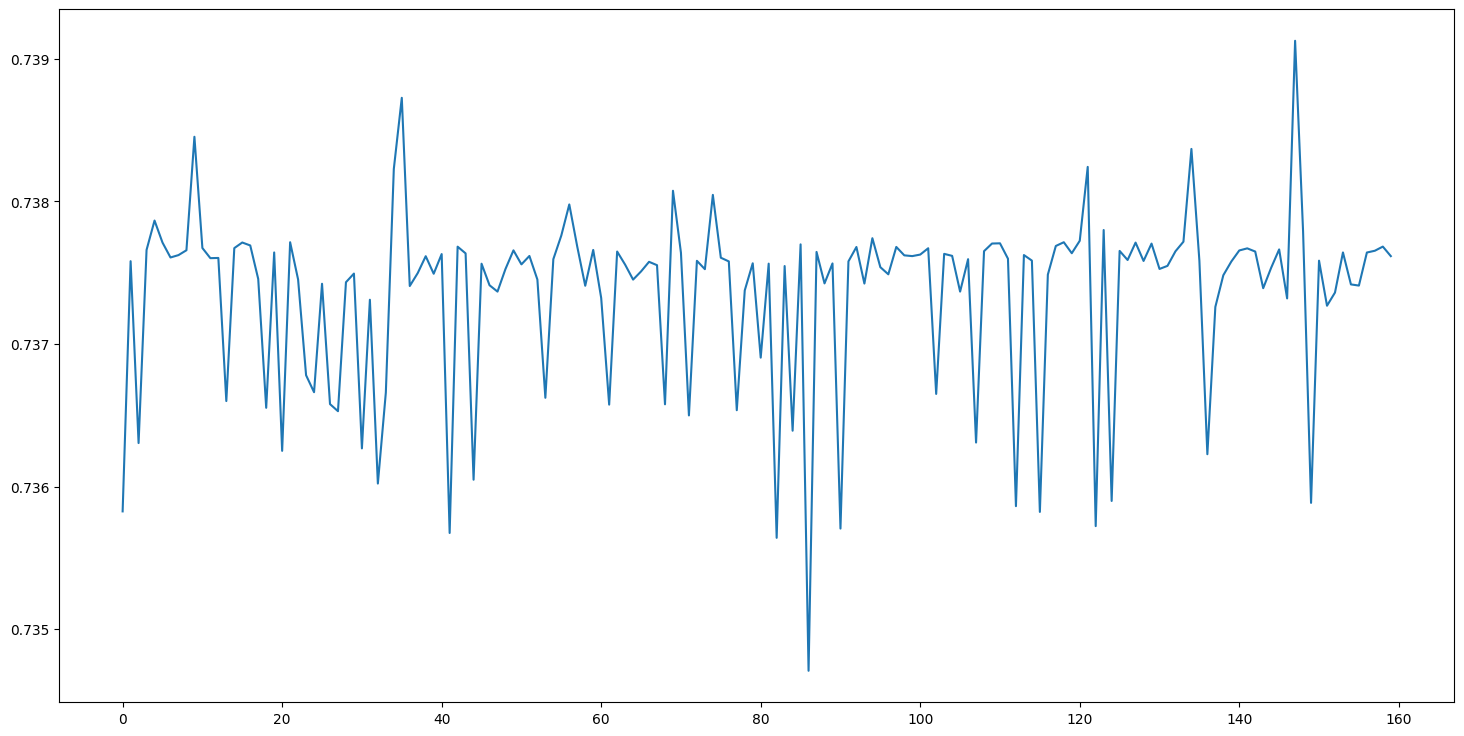

In [18]:
out_lst_cpu = np.array([o.detach().to("cpu") for o in out_lst]).squeeze()
target_lst_cpu = np.array([t.detach().to("cpu") for t in target_lst]).squeeze()
print(out_lst_cpu.shape)
print(target_lst_cpu.shape)
plt.figure(figsize=(18, 9))

plt.plot(out_lst_cpu[1])
# plt.plot(target_lst_cpu[1])

In [52]:
class SelfAttention1D(nn.Module):
    def __init__(self, channels):
        super(SelfAttention1D, self).__init__()
        # Query, Key, and Value projections
        self.query = nn.Conv1d(channels, channels // 8, kernel_size=1)
        self.key = nn.Conv1d(channels, channels // 8, kernel_size=1)
        self.value = nn.Conv1d(channels, channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))  # Learnable scaling factor for attention output

    def forward(self, x):
        batch_size, channels, seq_length = x.size()
        
        # Generate Query, Key, and Value
        query = self.query(x).permute(0, 2, 1)  # [batch_size, seq_length, channels // 8]
        key = self.key(x)  # [batch_size, channels // 8, seq_length]
        value = self.value(x)  # [batch_size, channels, seq_length]

        # Compute attention scores
        attention = torch.bmm(query, key)  # [batch_size, seq_length, seq_length]
        attention = torch.softmax(attention, dim=-1)  # Normalize attention scores

        # Apply attention to Value
        attention_output = torch.bmm(value, attention)  # [batch_size, channels, seq_length]

        # Scale and combine with the input
        return self.gamma * attention_output + x

In [12]:
inp = torch.rand(64, 1, 160)
down1 = nn.Conv1d(1, 128, 4, 2, padding_mode='replicate')
d1 = down1(inp)
print(d1.shape)
down2 = nn.Conv1d(128, 256, 4, 2, padding_mode='replicate')
d2 = down2(d1)
print(d2.shape)
down3 = nn.Conv1d(256, 512, 4, 2, padding_mode='replicate')
d3 = down3(d2)
print("d3 = ", d3.shape)
down4 = nn.Conv1d(512, 512, 4, 2, padding_mode='replicate')
d4 = down4(d3)
print(d4.shape)

up1 = nn.ConvTranspose1d(512, 512, 4, 2, output_padding=0)
u1 = up1(d4)
print("u1 = ", u1.shape)
u1 = torch.cat((u1, d3), 1)
print(u1.shape)
up2 = nn.ConvTranspose1d(1024, 256, 4, 2, output_padding=0)
u2 = up2(u1)
print(u2.shape)
u2 = torch.cat((u2, d2), 1)
up3 = nn.ConvTranspose1d(512, 128, 4, 2, output_padding=1)
u3 = up3(u2)
print(u3.shape)
u3 = torch.cat((u3, d1), 1)
print(u3.shape)
up_sample = nn.Upsample(scale_factor=2)
ups = up_sample(u3)
print(ups.shape)
padding = nn.ConstantPad1d((1, 1), 0)
pp = padding(ups)
print(pp.shape)
outp = nn.Conv1d(256, 1, 5, padding=2, padding_mode='replicate')
oo = outp(pp)
print(oo.shape)

torch.Size([64, 128, 79])
torch.Size([64, 256, 38])
d3 =  torch.Size([64, 512, 18])
torch.Size([64, 512, 8])
u1 =  torch.Size([64, 512, 18])
torch.Size([64, 1024, 18])
torch.Size([64, 256, 38])
torch.Size([64, 128, 79])
torch.Size([64, 256, 79])
torch.Size([64, 256, 158])
torch.Size([64, 256, 160])
torch.Size([64, 1, 160])


In [53]:
class GAN_Generator(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down1 = nn.Conv1d(1, 128, 4, 2, padding_mode='replicate')
        self.down2 = nn.Conv1d(128, 256, 4, 2, padding_mode='replicate')
        self.down3 = nn.Conv1d(256, 512, 4, 2, padding_mode='replicate')
        self.down4 = nn.Conv1d(512, 512, 4, 2, padding_mode='replicate')
        self.d_att1 = SelfAttention1D(128)
        self.d_att2 = SelfAttention1D(256)
        self.d_att3 = SelfAttention1D(512)
        self.d_att4 = SelfAttention1D(512)
        self.act1 = nn.ReLU()
        self.up1 = nn.ConvTranspose1d(512, 512, 4, 2, output_padding=0)
        self.up2 = nn.ConvTranspose1d(1024, 256, 4, 2, output_padding=0)
        self.up3 = nn.ConvTranspose1d(512, 128, 4, 2, output_padding=1)
        self.u_att1 = SelfAttention1D(512)
        self.u_att2 = SelfAttention1D(256)
        self.u_att3 = SelfAttention1D(128)
        self.up_sample = nn.Upsample(scale_factor=2)
        self.padding = nn.ConstantPad1d((1, 1), 0)
        self.outp = nn.Conv1d(256, out_channels, 5, padding=2, padding_mode='replicate')
        self.act2 = nn.Tanh()

    def forward(self, x):
        d1 = self.down1(x)
        d1 = self.d_att1(d1)
        d1 = self.act1(d1)
        d2 = self.down2(d1)
        d2 = self.d_att2(d2)
        d2 = self.act1(d2)
        d3 = self.down3(d2)
        d3 = self.d_att3(d3)
        d3 = self.act1(d3)
        d4 = self.down4(d3)
        d4 = self.d_att4(d4)
        d4 = self.act1(d4)

        u1 = self.up1(d4)
        u1 = self.u_att1(u1)
        u1 = torch.cat((u1, d3), 1)
        u2 = self.up2(u1)
        u2 = self.u_att2(u2)
        u2 = torch.cat((u2, d2), 1)
        u3 = self.up3(u2)
        u3 = self.u_att3(u3)
        u3 = torch.cat((u3, d1), 1)
        out = self.up_sample(u3)
        out = self.padding(out)
        out = self.outp(out)
        out = self.act2(out)
        return out

In [44]:
x = torch.rand(64, 2, 160)
conv1 = nn.Conv1d(2, 128, 6, 3, padding_mode='replicate')
x = conv1(x)
print(x.shape)
conv2 = nn.Conv1d(128, 256, 6, 3, padding_mode='replicate')
x = conv2(x)
print(x.shape)
conv3 = nn.Conv1d(256, 512, 6, 3, padding_mode='replicate')
x = conv3(x)
print(x.shape)
conv4 = nn.Conv1d(512, 1, 4, padding_mode='replicate')
x = conv4(x)
print(x.shape)
x = x.squeeze(1)
print(x.shape)

torch.Size([64, 128, 52])
torch.Size([64, 256, 16])
torch.Size([64, 512, 4])
torch.Size([64, 1, 1])
torch.Size([64, 1])


In [55]:
class GAN_Discriminator(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels * 2, 128, 6, 3, padding_mode='replicate')
        self.att1 = SelfAttention1D(128)
        self.conv2 = nn.Conv1d(128, 256, 6, 3, padding_mode='replicate')
        self.att2 = SelfAttention1D(256)
        self.conv3 = nn.Conv1d(256, 512, 6, 3, padding_mode='replicate')
        self.att3 = SelfAttention1D(512)
        self.conv4 = nn.Conv1d(512, out_channels, 4, padding_mode='replicate')
        self.act = nn.LeakyReLU(0.2)
        self.outp = nn.Sigmoid()
        # self.outp = nn.Tanh()

    def forward(self, d1, d2):
        x = torch.cat((d1, d2), 1)
        x = self.conv1(x)
        x = self.att1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.att2(x)
        x = self.act(x)
        x = self.conv3(x)
        x = self.att3(x)
        x = self.act(x)
        x = self.conv4(x)
        x = self.outp(x)
        x = x.squeeze(1)
        return x

In [21]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

def calculate_wa_loss(discriminator, real_ecg, fake_ecg, real_ppg):
    alpha = torch.rand((real_ecg.shape[0], 1, 1)).to(device)
    interpolates = (alpha * real_ecg + ((1 - alpha) * fake_ecg)).requires_grad_(True)
    d_interp = discriminator(interpolates, real_ppg)
    d_interp = d_interp.unsqueeze(1)
    fake = torch.full((real_ecg.shape[0], 1, 1), 1, dtype=torch.float32, device=device)

    grad = torch.autograd.grad(outputs=d_interp, inputs=interpolates, grad_outputs=fake, create_graph=True, retain_graph=True, only_inputs=True)[0]
    grad = grad.view(grad.shape[0], -1)
    grad_penalty = ((grad.norm(2, dim=1) - 1) ** 2).mean()
    return grad_penalty

In [30]:
num_epochs = 100

window_size = 160

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

generator = GAN_Generator()
discriminator = GAN_Discriminator()
generator = generator.to(torch.float32).to(device)
discriminator = discriminator.to(torch.float32).to(device)
dataset = PPG2ECGDataset(PPG[:50000], ECG[:50000])
dataloader = DataLoader(dataset, batch_size=64)


criterion = nn.MSELoss()
optimizer_G = optim.Adam(generator.parameters())
optimizer_D = optim.Adam(discriminator.parameters())

train_log = []

generator.train()
discriminator.train()
for epoch in range(num_epochs):
    # running_loss = 0
    for real_ppg, tgt, real_ecg in tqdm(dataloader):
        real_ppg = real_ppg.unsqueeze(1).to(device)

        real_ecg = real_ecg.unsqueeze(1).to(device)
        
        batch_size = src.shape[0]
        generator.train()
        for p in generator.parameters():
            p.grad = None
        fake_ecg = generator(real_ppg)
        # dtw_loss = combined_loss(fake_ecg, real_ecg)
        dtw_loss = criterion(fake_ecg, real_ecg)

        pred_fake = discriminator(fake_ecg, real_ppg)
        gan_loss = -torch.mean(pred_fake)
        g_loss = gan_loss + dtw_loss
        g_loss.backward()
        optimizer_G.step()

        for p in discriminator.parameters():
            p.grad = None
        pred_real = discriminator(real_ecg, real_ppg)
        pred_fake = discriminator(fake_ecg.detach(), real_ppg)
        # d_loss = -torch.mean(pred_real) + torch.mean(pred_fake) + calculate_wa_loss(discriminator, real_ecg, fake_ecg.detach(), real_ppg)
        d_loss = torch.mean(pred_real) + torch.mean(pred_fake)
        d_loss.backward()
        optimizer_D.step()
        
    print(f"Epoch {epoch}, d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")
    # train_log.append(running_loss / len(dataset))

    with open(f"train_loss_gan_wloss_epoch{epoch}.pkl", "wb") as f:
        pickle.dump(train_log, f)
    torch.save(generator.state_dict(), f"gan_generator_wloss.pth")
    torch.save(discriminator.state_dict(), f"gan_discriminator_wloss.pth")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:29<00:00, 26.01it/s]


Epoch 0, d_loss: -4.272019386291504, g_loss: 21.68728256225586


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.92it/s]


Epoch 1, d_loss: -4.237387657165527, g_loss: 45.0061149597168


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.92it/s]


Epoch 2, d_loss: -4.236176490783691, g_loss: 29.773534774780273


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.96it/s]


Epoch 3, d_loss: -4.2456135749816895, g_loss: 38.26836013793945


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.89it/s]


Epoch 4, d_loss: -4.309303283691406, g_loss: 27.509132385253906


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:29<00:00, 25.97it/s]


Epoch 5, d_loss: -4.283308506011963, g_loss: 42.43068313598633


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:29<00:00, 26.07it/s]


Epoch 6, d_loss: -4.293954849243164, g_loss: 16.42101287841797


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:29<00:00, 25.99it/s]


Epoch 7, d_loss: -4.4374566078186035, g_loss: 6.573625087738037


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.93it/s]


Epoch 8, d_loss: -4.2710981369018555, g_loss: 18.21027946472168


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.91it/s]


Epoch 9, d_loss: -4.295815467834473, g_loss: 26.5274600982666


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.90it/s]


Epoch 10, d_loss: -4.272856712341309, g_loss: -2.192538261413574


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.89it/s]


Epoch 11, d_loss: -4.291407585144043, g_loss: 21.52753257751465


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.96it/s]


Epoch 12, d_loss: -4.299785614013672, g_loss: 16.113054275512695


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.94it/s]


Epoch 13, d_loss: -4.294007301330566, g_loss: 25.393802642822266


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.94it/s]


Epoch 14, d_loss: -4.3040385246276855, g_loss: 12.546066284179688


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.90it/s]


Epoch 15, d_loss: -4.2106475830078125, g_loss: -88.8818588256836


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.90it/s]


Epoch 16, d_loss: -4.165661811828613, g_loss: 63.951473236083984


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.89it/s]


Epoch 17, d_loss: -4.24544620513916, g_loss: 55.92913818359375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.94it/s]


Epoch 18, d_loss: -4.300849914550781, g_loss: 20.428802490234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.92it/s]


Epoch 19, d_loss: -4.372101783752441, g_loss: 9.642340660095215


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.92it/s]


Epoch 20, d_loss: -4.385468482971191, g_loss: 41.36295700073242


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.94it/s]


Epoch 21, d_loss: -4.344148635864258, g_loss: 34.86124038696289


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.87it/s]


Epoch 22, d_loss: -4.386781215667725, g_loss: 38.66054916381836


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:29<00:00, 26.10it/s]


Epoch 23, d_loss: -4.400209903717041, g_loss: 39.031494140625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:29<00:00, 26.02it/s]


Epoch 24, d_loss: -4.3937811851501465, g_loss: 47.35533142089844


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.91it/s]


Epoch 25, d_loss: -4.302275657653809, g_loss: 34.90673828125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.89it/s]


Epoch 26, d_loss: -4.4200520515441895, g_loss: 6.517247200012207


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:29<00:00, 26.16it/s]


Epoch 27, d_loss: -4.325787544250488, g_loss: 9.550110816955566


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.91it/s]


Epoch 28, d_loss: -4.319811820983887, g_loss: 4.728874206542969


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.93it/s]


Epoch 29, d_loss: -4.287540435791016, g_loss: -58.97871398925781


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:29<00:00, 26.02it/s]


Epoch 30, d_loss: -4.333250999450684, g_loss: -0.7482143044471741


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.95it/s]


Epoch 31, d_loss: -4.275167942047119, g_loss: 9.27547836303711


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.96it/s]


Epoch 32, d_loss: -4.3590850830078125, g_loss: 7.589400291442871


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.89it/s]


Epoch 33, d_loss: -4.326061248779297, g_loss: 27.056896209716797


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.93it/s]


Epoch 34, d_loss: -4.372799873352051, g_loss: 9.582291603088379


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:29<00:00, 26.00it/s]


Epoch 35, d_loss: -4.367817401885986, g_loss: 23.417449951171875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.94it/s]


Epoch 36, d_loss: -4.309016704559326, g_loss: 15.569663047790527


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.86it/s]


Epoch 37, d_loss: -4.310155868530273, g_loss: 20.549152374267578


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.95it/s]


Epoch 38, d_loss: -4.348875999450684, g_loss: 24.571977615356445


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.91it/s]


Epoch 39, d_loss: -4.2881879806518555, g_loss: -17.345705032348633


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:29<00:00, 26.12it/s]


Epoch 40, d_loss: -4.301664352416992, g_loss: 20.64887237548828


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.94it/s]


Epoch 41, d_loss: -4.32661247253418, g_loss: 26.68515968322754


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:29<00:00, 26.08it/s]


Epoch 42, d_loss: -4.393781661987305, g_loss: 3.9012415409088135


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:29<00:00, 25.98it/s]


Epoch 43, d_loss: -4.266497611999512, g_loss: 14.383161544799805


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:29<00:00, 25.97it/s]


Epoch 44, d_loss: -4.313730239868164, g_loss: 9.192037582397461


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:29<00:00, 26.04it/s]


Epoch 45, d_loss: -4.39251184463501, g_loss: 15.867262840270996


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.89it/s]


Epoch 46, d_loss: -4.260580539703369, g_loss: -1.2475560903549194


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.95it/s]


Epoch 47, d_loss: -4.286168098449707, g_loss: 1.6932041645050049


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.92it/s]


Epoch 48, d_loss: -4.262142181396484, g_loss: 15.004012107849121


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:29<00:00, 26.50it/s]


Epoch 49, d_loss: -4.261293888092041, g_loss: -5.2405686378479


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:29<00:00, 26.07it/s]


Epoch 50, d_loss: -5.6960368156433105, g_loss: -404.552978515625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:29<00:00, 26.21it/s]


Epoch 51, d_loss: -4.25015926361084, g_loss: -14.120109558105469


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.96it/s]


Epoch 52, d_loss: -4.3732147216796875, g_loss: -20.65092658996582


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:29<00:00, 26.02it/s]


Epoch 53, d_loss: -4.326854705810547, g_loss: -9.62795639038086


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.93it/s]


Epoch 54, d_loss: -4.323148727416992, g_loss: -29.525028228759766


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:29<00:00, 26.02it/s]


Epoch 55, d_loss: -4.321383476257324, g_loss: -5.669791221618652


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.94it/s]


Epoch 56, d_loss: -4.305034160614014, g_loss: 8.789458274841309


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.95it/s]


Epoch 57, d_loss: -4.34323787689209, g_loss: 10.075282096862793


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.91it/s]


Epoch 58, d_loss: -4.38386344909668, g_loss: -17.650083541870117


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.92it/s]


Epoch 59, d_loss: -4.285647392272949, g_loss: -9.189915657043457


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:29<00:00, 25.97it/s]


Epoch 60, d_loss: -4.283154487609863, g_loss: 12.358513832092285


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.96it/s]


Epoch 61, d_loss: -4.326729774475098, g_loss: 10.678156852722168


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:29<00:00, 25.99it/s]


Epoch 62, d_loss: -4.302762031555176, g_loss: 10.954710960388184


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:29<00:00, 25.99it/s]


Epoch 63, d_loss: -4.299825668334961, g_loss: 44.036705017089844


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.94it/s]


Epoch 64, d_loss: -4.294262886047363, g_loss: 17.86798667907715


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.91it/s]


Epoch 65, d_loss: -4.262307167053223, g_loss: -6.4588704109191895


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.94it/s]


Epoch 66, d_loss: -4.338866233825684, g_loss: 11.86401653289795


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:29<00:00, 26.09it/s]


Epoch 67, d_loss: -4.302918434143066, g_loss: 15.110697746276855


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:29<00:00, 26.20it/s]


Epoch 68, d_loss: -4.283151149749756, g_loss: 14.640538215637207


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.89it/s]


Epoch 69, d_loss: -4.302865982055664, g_loss: -0.5325638055801392


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.96it/s]


Epoch 70, d_loss: -4.298245906829834, g_loss: 17.322572708129883


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:29<00:00, 26.01it/s]


Epoch 71, d_loss: -4.2868781089782715, g_loss: -10.267455101013184


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.85it/s]


Epoch 72, d_loss: -4.29460334777832, g_loss: -3.0139408111572266


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.87it/s]


Epoch 73, d_loss: -4.234448432922363, g_loss: 11.389688491821289


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.94it/s]


Epoch 74, d_loss: -4.288006782531738, g_loss: 9.453913688659668


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.96it/s]


Epoch 75, d_loss: -4.25120735168457, g_loss: 13.960897445678711


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:29<00:00, 26.17it/s]


Epoch 76, d_loss: -4.258276462554932, g_loss: -2.8101370334625244


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.93it/s]


Epoch 77, d_loss: -4.3015289306640625, g_loss: -6.26051139831543


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:29<00:00, 25.97it/s]


Epoch 78, d_loss: -4.396535396575928, g_loss: -2.5839247703552246


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.94it/s]


Epoch 79, d_loss: -4.257326126098633, g_loss: -123.65887451171875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:29<00:00, 26.11it/s]


Epoch 80, d_loss: -4.231051445007324, g_loss: -15.972555160522461


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.92it/s]


Epoch 81, d_loss: -4.280231475830078, g_loss: 2.3796885013580322


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.88it/s]


Epoch 82, d_loss: -4.217094898223877, g_loss: -12.571901321411133


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:29<00:00, 26.04it/s]


Epoch 83, d_loss: -4.307688236236572, g_loss: -26.630001068115234


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.96it/s]


Epoch 84, d_loss: -4.234128475189209, g_loss: -7.393259048461914


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.95it/s]


Epoch 85, d_loss: -4.28974723815918, g_loss: -2.939481258392334


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:29<00:00, 25.97it/s]


Epoch 86, d_loss: -4.269092559814453, g_loss: 6.716482162475586


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.93it/s]


Epoch 87, d_loss: -4.3104705810546875, g_loss: 21.959732055664062


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.94it/s]


Epoch 88, d_loss: -4.2271270751953125, g_loss: -2.0836222171783447


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.92it/s]


Epoch 89, d_loss: -4.328126907348633, g_loss: 5.8073601722717285


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.94it/s]


Epoch 90, d_loss: -4.304502964019775, g_loss: 10.61122989654541


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:29<00:00, 26.03it/s]


Epoch 91, d_loss: -4.277858734130859, g_loss: 20.150531768798828


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.90it/s]


Epoch 92, d_loss: -4.278879642486572, g_loss: 26.73026466369629


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:29<00:00, 25.97it/s]


Epoch 93, d_loss: -4.297993183135986, g_loss: 12.82797908782959


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.93it/s]


Epoch 94, d_loss: -4.338711738586426, g_loss: -26.053258895874023


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.86it/s]


Epoch 95, d_loss: -4.31085205078125, g_loss: 7.755070686340332


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.88it/s]


Epoch 96, d_loss: -4.286795139312744, g_loss: -1.715326189994812


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.95it/s]


Epoch 97, d_loss: -4.315794944763184, g_loss: 18.245437622070312


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:30<00:00, 25.95it/s]


Epoch 98, d_loss: -4.259751796722412, g_loss: 9.242419242858887


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [00:29<00:00, 26.07it/s]


Epoch 99, d_loss: -4.282879829406738, g_loss: -4.307273864746094


In [32]:
# Test 
test_dataset = PPG2ECGDataset(PPG[50001:51000], ECG[50001:51000])
test_dataloader = DataLoader(test_dataset, batch_size=1)
generator = GAN_Generator()
generator = generator.to(torch.float32)
generator.load_state_dict(torch.load("gan_generator_wloss.pth", weights_only=True))
criterion = nn.MSELoss()

test_log = []
out_lst = []
target_lst = []
device = "cpu"
generator.to(device)

for src, tgt, target in tqdm(test_dataloader):
    src = src.unsqueeze(1).to(device)
    # tgt = tgt.to(device)
    target = target.unsqueeze(1)
    target = target.to(device)
    out = generator(src)
    out = out.to(device)
    out_lst.append(out)
    target_lst.append(target)
    # loss = criterion(out, target)
    loss = combined_loss(out, target)
    test_log.append(loss.item())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 840/840 [00:07<00:00, 119.21it/s]


(840, 160)
(840, 160)


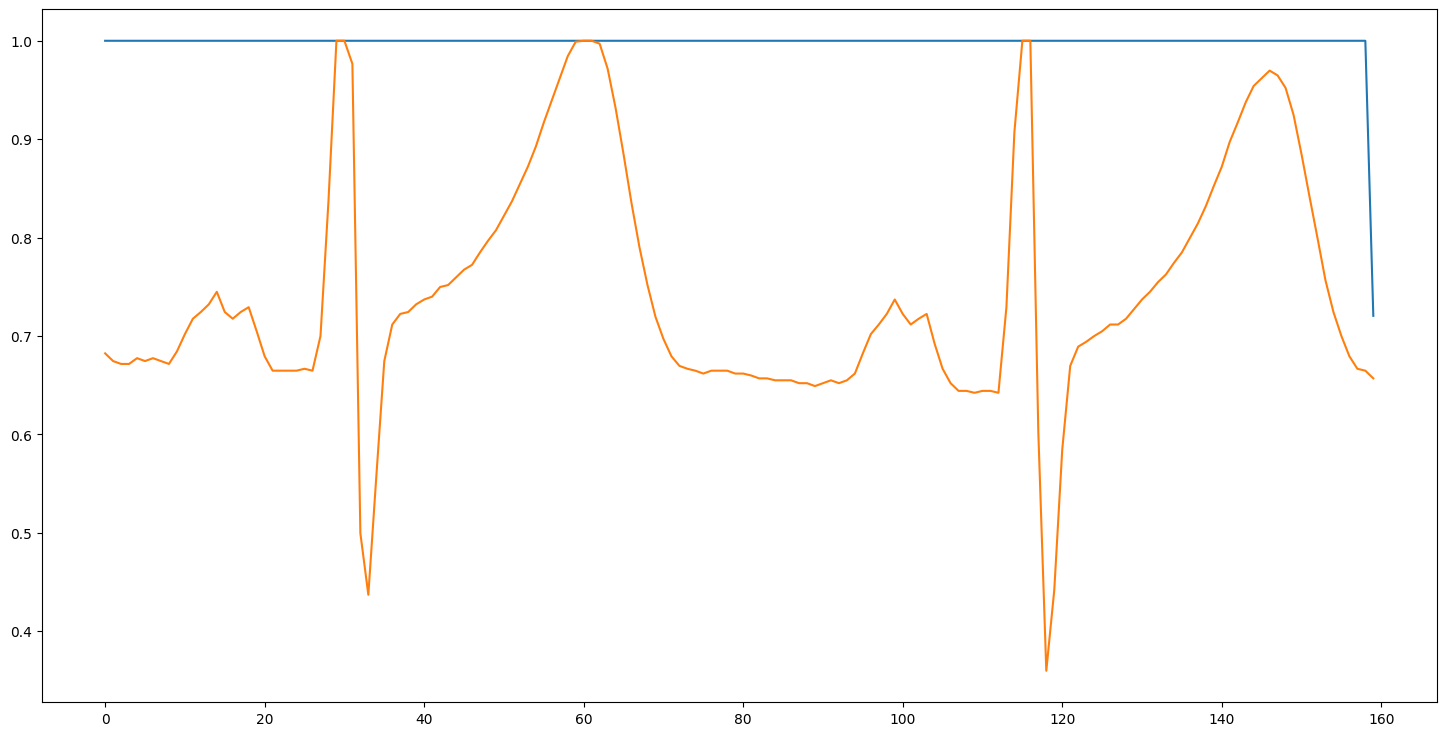

In [35]:
out_lst_cpu = np.array([o.detach().to("cpu") for o in out_lst]).squeeze()
target_lst_cpu = np.array([t.detach().to("cpu") for t in target_lst]).squeeze()
print(out_lst_cpu.shape)
print(target_lst_cpu.shape)
plt.figure(figsize=(18, 9))

plt.plot(out_lst_cpu[0])
plt.plot(target_lst_cpu[0])

In [57]:
def get_peak_loss(pred, target):
    pred_derivative = torch.diff(pred, dim=-1)
    target_derivative = torch.diff(target, dim=-1)
    return nn.L1Loss()(pred_derivative, target_derivative)

In [70]:
def detect_peaks(signal, height=None, distance=None):
    peaks, _ = find_peaks(signal, height=height, distance=distance)
    return peaks

def align_peaks(pred_peaks, target_peaks):
    aligned_pred = []
    aligned_target = []
    
    for target in target_peaks:
        # Find the nearest peak in predicted peaks
        distances = torch.abs(pred_peaks - target)
        nearest_idx = torch.argmin(distances)
        aligned_pred.append(pred_peaks[nearest_idx])
        aligned_target.append(target)

    return torch.stack(aligned_pred), torch.stack(aligned_target)

def peak_alignment_loss(pred, target, height=None, distance=None):
    loss = 0
    batch_size = pred.shape[0]
    for i in range(batch_size):
        # Convert signals to NumPy arrays for peak detection
        pred_np = pred[i, 0].detach().cpu().numpy()
        target_np = target[i, 0].detach().cpu().numpy()

        # Detect peaks
        pred_peaks = detect_peaks(pred_np, height=height, distance=distance)
        target_peaks = detect_peaks(target_np, height=height, distance=distance)
        # print(pred_peaks.shape)
        # print(target_peaks.shape)

        # Compute L2 distance between matched peaks
        if len(pred_peaks) > 0 and len(target_peaks) > 0:
            pred_peaks_tensor = torch.tensor(pred_peaks, device=pred.device).to(torch.float32)
            target_peaks_tensor = torch.tensor(target_peaks, device=pred.device).to(torch.float32)
            aligned_pred, aligned_target = align_peaks(pred_peaks_tensor, target_peaks_tensor)
            loss += torch.mean((aligned_pred - aligned_target) ** 2)

    return loss / batch_size

In [51]:
class SelfAttention1D(nn.Module):
    def __init__(self, channels):
        super().__init__()
        # Query, Key, and Value projections
        self.query = nn.Conv1d(channels, channels // 8, kernel_size=1)
        self.key = nn.Conv1d(channels, channels // 8, kernel_size=1)
        self.value = nn.Conv1d(channels, channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))  # Learnable scaling factor for attention output

    def forward(self, x):
        batch_size, channels, seq_length = x.shape()
        
        # Generate Query, Key, and Value
        query = self.query(x).permute(0, 2, 1)  # [batch_size, seq_length, channels // 8]
        key = self.key(x)  # [batch_size, channels // 8, seq_length]
        value = self.value(x)  # [batch_size, channels, seq_length]

        # Compute attention scores
        attention = torch.bmm(query, key)  # [batch_size, seq_length, seq_length]
        attention = torch.softmax(attention, dim=-1)  # Normalize attention scores

        # Apply attention to Value
        attention_output = torch.bmm(value, attention)  # [batch_size, channels, seq_length]

        # Scale and combine with the input
        return self.gamma * attention_output + x

In [89]:
num_epochs = 100

window_size = 160

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

generator = GAN_Generator().to(device)
discriminator = GAN_Discriminator().to(device)
generator = generator.to(torch.float32).to(device)
discriminator = discriminator.to(torch.float32).to(device)
dataset = PPG2ECGDataset(PPG[:50000], ECG[:50000])
dataloader = DataLoader(dataset, batch_size=512)


# criterion = nn.MSELoss()
adversarial_loss = nn.BCELoss()
# lr = 10e-4
optimizer_G = optim.Adam(generator.parameters(), weight_decay=0.1)
optimizer_D = optim.Adam(discriminator.parameters(), weight_decay=0.1)

# schedular_G = optim.lr_schedular.StepLR(optimizer_G, step_size=10, gamma=0.1)
# schedular_D = optim.lr_schedular.StepLR(optimizer_D, step_size=10, gamma=0.1)

train_log = []

generator.train()
discriminator.train()
for epoch in range(num_epochs):
    # running_loss = 0
    for real_ppg, tgt, real_ecg in tqdm(dataloader):
        real_ppg = real_ppg.unsqueeze(1).to(device)
        real_ecg = real_ecg.unsqueeze(1).to(device)

        batch_size = real_ppg.shape[0]
        # print(batch_size)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train discriminator real
        optimizer_D.zero_grad()
        pred_real = discriminator(real_ecg, real_ppg)
        d_loss_real = adversarial_loss(pred_real, real_labels)
        # d_loss_real.backward()

        # Train discriminator fake
        fake_ecg = generator(real_ppg)
        pred_fake = discriminator(fake_ecg, real_ppg)
        d_loss_fake = adversarial_loss(pred_fake, fake_labels)
        # d_loss_fake.backward()

        d_loss = (d_loss_real + d_loss_fake) * 1
        d_loss += calculate_wa_loss(discriminator, real_ecg, fake_ecg, real_ppg)
        d_loss.backward()
        optimizer_D.step()
        
        # Train generator
        optimizer_G.zero_grad()
        fake_ecg = generator(real_ppg)
        pred_fake = discriminator(fake_ecg, real_ppg)
        g_loss = adversarial_loss(pred_fake, real_labels)
        # peak_loss = get_peak_loss(fake_ecg, real_ecg)
        peak_loss = peak_alignment_loss(fake_ecg, real_ecg, height=0.3, distance=10)
        g_loss += combined_loss(fake_ecg, real_ecg)
        g_loss += peak_loss
        
        
        g_loss.backward()

        optimizer_G.step()

    # schedular_D.step()
    # schedular_G.step()
    print(f"Epoch {epoch}, d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")
    # train_log.append(running_loss / len(dataset))

    with open(f"train_loss_gan_att_peakalign_epoch{epoch}.pkl", "wb") as f:
        pickle.dump(train_log, f)
    torch.save(generator.state_dict(), f"gan_generator_att_peakalign.pth")
    torch.save(discriminator.state_dict(), f"gan_discriminator_att_peakalign.pth")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.87it/s]


Epoch 0, d_loss: 2.3834128379821777, g_loss: 155.35887145996094


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.78it/s]


Epoch 1, d_loss: 2.351912260055542, g_loss: 184.95733642578125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.72it/s]


Epoch 2, d_loss: 2.2712671756744385, g_loss: 230.48776245117188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.73it/s]


Epoch 3, d_loss: 2.099885940551758, g_loss: 217.8019256591797


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.87it/s]


Epoch 4, d_loss: 0.6929754018783569, g_loss: 586.557373046875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.75it/s]


Epoch 5, d_loss: 1.20823073387146, g_loss: 341.96331787109375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.74it/s]


Epoch 6, d_loss: 2.1271016597747803, g_loss: 660.4713134765625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.75it/s]


Epoch 7, d_loss: 1.6224839687347412, g_loss: 214.9417266845703


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.80it/s]


Epoch 8, d_loss: 1.3177767992019653, g_loss: 52.16566467285156


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.79it/s]


Epoch 9, d_loss: 1.401310920715332, g_loss: 52.086910247802734


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.76it/s]


Epoch 10, d_loss: 0.7656322121620178, g_loss: 16.73343849182129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.77it/s]


Epoch 11, d_loss: 0.7224947214126587, g_loss: 1400.07861328125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.74it/s]


Epoch 12, d_loss: 0.7509201169013977, g_loss: 15.928593635559082


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.73it/s]


Epoch 13, d_loss: 0.7316667437553406, g_loss: 152.6558837890625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.73it/s]


Epoch 14, d_loss: 0.858363926410675, g_loss: 194.78675842285156


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.74it/s]


Epoch 15, d_loss: 0.6094883680343628, g_loss: 763.9690551757812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.74it/s]


Epoch 16, d_loss: 0.7845179438591003, g_loss: 194.59915161132812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.77it/s]


Epoch 17, d_loss: 0.7820976376533508, g_loss: 5149.21533203125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.74it/s]


Epoch 18, d_loss: 0.5488530993461609, g_loss: 206.1783905029297


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.75it/s]


Epoch 19, d_loss: 2.3802144527435303, g_loss: 45.13304901123047


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.73it/s]


Epoch 20, d_loss: 0.7018434405326843, g_loss: 197.54478454589844


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.76it/s]


Epoch 21, d_loss: 0.8618122339248657, g_loss: 64.17138671875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.73it/s]


Epoch 22, d_loss: 2.0412721633911133, g_loss: 4975.12060546875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.73it/s]


Epoch 23, d_loss: 0.8249094486236572, g_loss: 211.3665313720703


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.74it/s]


Epoch 24, d_loss: 1.798680305480957, g_loss: 28.371898651123047


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.73it/s]


Epoch 25, d_loss: 0.6055734753608704, g_loss: 179.61758422851562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.72it/s]


Epoch 26, d_loss: 1.5249121189117432, g_loss: 22.15314483642578


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.73it/s]


Epoch 27, d_loss: 0.6589091420173645, g_loss: 195.80856323242188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.73it/s]


Epoch 28, d_loss: 1.4212467670440674, g_loss: 52.50594711303711


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.75it/s]


Epoch 29, d_loss: 0.7477578520774841, g_loss: 178.5973663330078


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.73it/s]


Epoch 30, d_loss: 1.895321249961853, g_loss: 31.408653259277344


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.72it/s]


Epoch 31, d_loss: 0.8366517424583435, g_loss: 27.421611785888672


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:57<00:00,  1.71it/s]


Epoch 32, d_loss: 0.59663987159729, g_loss: 26.468040466308594


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.72it/s]


Epoch 33, d_loss: 0.5905914902687073, g_loss: 38.38383102416992


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.73it/s]


Epoch 34, d_loss: 0.6006289720535278, g_loss: 38.06191635131836


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.75it/s]


Epoch 35, d_loss: 3.037203788757324, g_loss: 70.98783111572266


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.75it/s]


Epoch 36, d_loss: 1.5536445379257202, g_loss: 55.67283248901367


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.73it/s]


Epoch 37, d_loss: 0.8734443187713623, g_loss: 17.977928161621094


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.73it/s]


Epoch 38, d_loss: 0.6637598872184753, g_loss: 50.70484161376953


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.73it/s]


Epoch 39, d_loss: 0.6841124892234802, g_loss: 50.801570892333984


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:57<00:00,  1.72it/s]


Epoch 40, d_loss: 0.5987546443939209, g_loss: 212.0192413330078


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.75it/s]


Epoch 41, d_loss: 0.5736181735992432, g_loss: 197.97335815429688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:57<00:00,  1.72it/s]


Epoch 42, d_loss: 0.4366067051887512, g_loss: 186.7903594970703


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.75it/s]


Epoch 43, d_loss: 0.7556032538414001, g_loss: 176.628662109375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.75it/s]


Epoch 44, d_loss: 0.8104032874107361, g_loss: 56.8282356262207


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.73it/s]


Epoch 45, d_loss: 0.8501010537147522, g_loss: 5234.0791015625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:57<00:00,  1.72it/s]


Epoch 46, d_loss: 0.4581335186958313, g_loss: 64.74271392822266


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.72it/s]


Epoch 47, d_loss: 2.683650493621826, g_loss: 41.18151092529297


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.73it/s]


Epoch 48, d_loss: 0.42159798741340637, g_loss: 83.80428314208984


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.74it/s]


Epoch 49, d_loss: 0.43154454231262207, g_loss: 56.88630294799805


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.74it/s]


Epoch 50, d_loss: 0.6012977361679077, g_loss: 53.65921401977539


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.79it/s]


Epoch 51, d_loss: 0.588593065738678, g_loss: 52.38687515258789


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.73it/s]


Epoch 52, d_loss: 0.6153569221496582, g_loss: 31.601661682128906


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.73it/s]


Epoch 53, d_loss: 1.1841002702713013, g_loss: 34.80756378173828


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.74it/s]


Epoch 54, d_loss: 1.0499696731567383, g_loss: 22.965818405151367


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.73it/s]


Epoch 55, d_loss: 1.121113896369934, g_loss: 37.058753967285156


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:57<00:00,  1.72it/s]


Epoch 56, d_loss: 1.3239693641662598, g_loss: 21.401708602905273


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:56<00:00,  1.73it/s]


Epoch 57, d_loss: 1.150160789489746, g_loss: 89.06118774414062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:57<00:00,  1.72it/s]


Epoch 58, d_loss: 1.1143741607666016, g_loss: 60.06522750854492


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.76it/s]


Epoch 59, d_loss: 1.271903157234192, g_loss: 49.33479309082031


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.78it/s]


Epoch 60, d_loss: 1.322243571281433, g_loss: 28.52548599243164


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.78it/s]


Epoch 61, d_loss: 1.3645274639129639, g_loss: 14.659895896911621


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.77it/s]


Epoch 62, d_loss: 1.3481173515319824, g_loss: 11.735797882080078


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.78it/s]


Epoch 63, d_loss: 1.2368674278259277, g_loss: 17.82678985595703


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.78it/s]


Epoch 64, d_loss: 0.4597066640853882, g_loss: 32.06010437011719


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 65, d_loss: 1.0276596546173096, g_loss: 19.000253677368164


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.77it/s]


Epoch 66, d_loss: 0.5489463806152344, g_loss: 33.44697952270508


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.77it/s]


Epoch 67, d_loss: 0.7109293341636658, g_loss: 36.158206939697266


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.78it/s]


Epoch 68, d_loss: 0.5466709136962891, g_loss: 199.64915466308594


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.77it/s]


Epoch 69, d_loss: 0.7766568660736084, g_loss: 634.536376953125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.79it/s]


Epoch 70, d_loss: 0.481225848197937, g_loss: 191.04771423339844


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.79it/s]


Epoch 71, d_loss: 0.6959948539733887, g_loss: 420.101318359375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.78it/s]


Epoch 72, d_loss: 0.47333240509033203, g_loss: 121.06777954101562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.79it/s]


Epoch 73, d_loss: 0.7391734719276428, g_loss: 49.27119064331055


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.79it/s]


Epoch 74, d_loss: 0.42459648847579956, g_loss: 191.454833984375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.79it/s]


Epoch 75, d_loss: 0.6735773682594299, g_loss: 582.9359741210938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 76, d_loss: 0.6447903513908386, g_loss: 218.53953552246094


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.80it/s]


Epoch 77, d_loss: 0.4566223621368408, g_loss: 202.34532165527344


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.79it/s]


Epoch 78, d_loss: 0.4324479103088379, g_loss: 101.85491943359375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.79it/s]


Epoch 79, d_loss: 0.48941922187805176, g_loss: 60.00956726074219


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.79it/s]


Epoch 80, d_loss: 0.4668569564819336, g_loss: 187.79400634765625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.79it/s]


Epoch 81, d_loss: 1.388900876045227, g_loss: 20.314857482910156


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.79it/s]


Epoch 82, d_loss: 0.5311916470527649, g_loss: 21.576580047607422


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.79it/s]


Epoch 83, d_loss: 0.44843265414237976, g_loss: 45.16725158691406


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.77it/s]


Epoch 84, d_loss: 0.6428292989730835, g_loss: 124.62229919433594


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.78it/s]


Epoch 85, d_loss: 1.1231807470321655, g_loss: 23.202472686767578


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.76it/s]


Epoch 86, d_loss: 0.5460206270217896, g_loss: 125.76998138427734


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.76it/s]


Epoch 87, d_loss: 0.7090705633163452, g_loss: 279.5729064941406


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.78it/s]


Epoch 88, d_loss: 1.5251339673995972, g_loss: 31.07284164428711


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.78it/s]


Epoch 89, d_loss: 1.383819818496704, g_loss: 31.375520706176758


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.78it/s]


Epoch 90, d_loss: 1.0824263095855713, g_loss: 21.580852508544922


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.78it/s]


Epoch 91, d_loss: 0.647431492805481, g_loss: 37.051517486572266


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.77it/s]


Epoch 92, d_loss: 1.670135498046875, g_loss: 24.161293029785156


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.79it/s]


Epoch 93, d_loss: 1.0620869398117065, g_loss: 185.8184814453125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.79it/s]


Epoch 94, d_loss: 1.0578464269638062, g_loss: 39.21791076660156


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.78it/s]


Epoch 95, d_loss: 1.0211230516433716, g_loss: 58.62562561035156


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.77it/s]


Epoch 96, d_loss: 0.7179899215698242, g_loss: 64.74024963378906


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.77it/s]


Epoch 97, d_loss: 0.7438063621520996, g_loss: 53.26205062866211


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.76it/s]


Epoch 98, d_loss: 1.6021437644958496, g_loss: 45.80293273925781


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.77it/s]

Epoch 99, d_loss: 1.5347208976745605, g_loss: 33.57078552246094


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 840/840 [00:12<00:00, 68.57it/s]


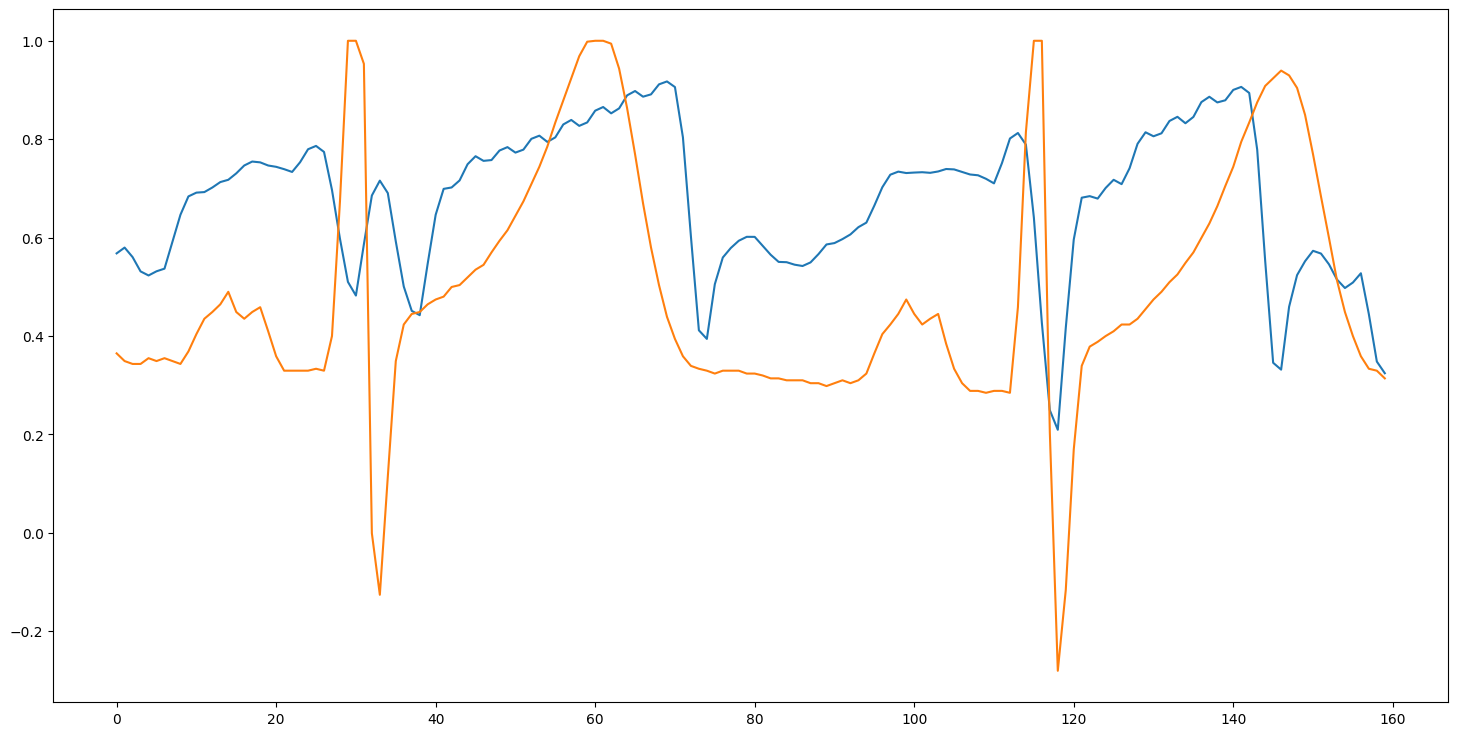

In [90]:
# Test 
test_dataset = PPG2ECGDataset(PPG[50001:51000], ECG[50001:51000])
test_dataloader = DataLoader(test_dataset, batch_size=1)
# generator = GAN_Generator()
# generator = generator.to(torch.float32)
# generator.load_state_dict(torch.load("gan_generator_bceloss.pth", weights_only=True))
# criterion = nn.MSELoss()

test_log = []
out_lst = []
target_lst = []
device = "cpu"
generator.to(device)

for src, tgt, target in tqdm(test_dataloader):
    src = src.unsqueeze(1).to(device)
    # tgt = tgt.to(device)
    target = target.unsqueeze(1)
    target = target.to(device)
    out = generator(src)
    out = out.to(device)
    out_lst.append(out)
    target_lst.append(target)
    # loss = criterion(out, target)
    loss = combined_loss(out, target)
    test_log.append(loss.item())


out_lst_cpu = np.array([o.detach().to("cpu") for o in out_lst]).squeeze()
target_lst_cpu = np.array([t.detach().to("cpu") for t in target_lst]).squeeze()
# print(out_lst_cpu.shape)
# print(target_lst_cpu.shape)
plt.figure(figsize=(18, 9))

plt.plot(out_lst_cpu[0])
plt.plot(target_lst_cpu[0])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:51<00:00,  1.92it/s]


Epoch 0, d_loss: 1003.38671875, g_loss: 8.034205436706543


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:32<00:00,  2.99it/s]


Epoch 1, d_loss: 74.75709533691406, g_loss: 20.557415008544922


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 2, d_loss: 14.775740623474121, g_loss: 7503.611328125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.79it/s]


Epoch 3, d_loss: 18.882192611694336, g_loss: 518.91064453125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:49<00:00,  1.96it/s]


Epoch 4, d_loss: 14.981230735778809, g_loss: 383.5577697753906


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.88it/s]


Epoch 5, d_loss: 14.442252159118652, g_loss: 780.4935913085938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.78it/s]


Epoch 6, d_loss: 14.281893730163574, g_loss: 592.56298828125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:49<00:00,  2.00it/s]


Epoch 7, d_loss: 101.5540542602539, g_loss: 3690.84765625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.80it/s]


Epoch 8, d_loss: 0.8793347477912903, g_loss: 32.98037338256836


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.78it/s]


Epoch 9, d_loss: 13.866530418395996, g_loss: 35.16069030761719


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:51<00:00,  1.89it/s]


Epoch 10, d_loss: 10.37119197845459, g_loss: 36.77507400512695


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.80it/s]


Epoch 11, d_loss: 17.362417221069336, g_loss: 10.676420211791992


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:46<00:00,  2.09it/s]


Epoch 12, d_loss: 3.7287681102752686, g_loss: 45.57853698730469


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.81it/s]


Epoch 13, d_loss: 14.30242919921875, g_loss: 33.44486618041992


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.77it/s]


Epoch 14, d_loss: 10.981693267822266, g_loss: 15.094711303710938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.78it/s]


Epoch 15, d_loss: 8.443746566772461, g_loss: 27.039323806762695


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.75it/s]


Epoch 16, d_loss: 2.3308019638061523, g_loss: 51.462501525878906


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.76it/s]


Epoch 17, d_loss: 13.642531394958496, g_loss: 105.8782958984375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.76it/s]


Epoch 18, d_loss: 10.108060836791992, g_loss: 250.0673065185547


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.78it/s]


Epoch 19, d_loss: 11.024157524108887, g_loss: 27.65805435180664


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.78it/s]


Epoch 20, d_loss: 12.012993812561035, g_loss: 22.795310974121094


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:50<00:00,  1.95it/s]


Epoch 21, d_loss: 0.8642786145210266, g_loss: 39.786800384521484


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 22, d_loss: 10.117541313171387, g_loss: 48.5467643737793


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.78it/s]


Epoch 23, d_loss: 10.57894229888916, g_loss: 27.70345687866211


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.78it/s]


Epoch 24, d_loss: 9.24275016784668, g_loss: 27.89116668701172


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.78it/s]


Epoch 25, d_loss: 6.969573020935059, g_loss: 17.038854598999023


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 26, d_loss: 0.9006444215774536, g_loss: 24.475404739379883


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:45<00:00,  2.18it/s]


Epoch 27, d_loss: 0.7456197738647461, g_loss: 31.01987075805664


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.78it/s]


Epoch 28, d_loss: 4.077696800231934, g_loss: 1144.4901123046875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.78it/s]


Epoch 29, d_loss: 11.290836334228516, g_loss: 150.57052612304688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.78it/s]


Epoch 30, d_loss: 11.623604774475098, g_loss: 26.383554458618164


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.78it/s]


Epoch 31, d_loss: 9.71372127532959, g_loss: 17.775293350219727


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.76it/s]


Epoch 32, d_loss: 11.613043785095215, g_loss: 19.722604751586914


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.76it/s]


Epoch 33, d_loss: 11.8225736618042, g_loss: 33.272430419921875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.80it/s]


Epoch 34, d_loss: 66.28067016601562, g_loss: 47.6405143737793


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:51<00:00,  1.89it/s]


Epoch 35, d_loss: 0.8326466083526611, g_loss: 9.398575782775879


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 36, d_loss: 2.8396570682525635, g_loss: 254.98794555664062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.77it/s]


Epoch 37, d_loss: 9.067154884338379, g_loss: 26.553356170654297


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.76it/s]


Epoch 38, d_loss: 10.955533027648926, g_loss: 23.12913703918457


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.77it/s]


Epoch 39, d_loss: 11.174044609069824, g_loss: 16.61387825012207


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.76it/s]


Epoch 40, d_loss: 7.627950191497803, g_loss: 17.332014083862305


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:51<00:00,  1.91it/s]


Epoch 41, d_loss: 2.8309617042541504, g_loss: 598.2531127929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.79it/s]


Epoch 42, d_loss: 10.238909721374512, g_loss: 38.96784591674805


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.77it/s]


Epoch 43, d_loss: 16.709732055664062, g_loss: 28.004240036010742


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.76it/s]


Epoch 44, d_loss: 7.735300540924072, g_loss: 17.823413848876953


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.77it/s]


Epoch 45, d_loss: 10.127777099609375, g_loss: 26.42643165588379


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.78it/s]


Epoch 46, d_loss: 13.273005485534668, g_loss: 49.77451705932617


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.76it/s]


Epoch 47, d_loss: 12.121007919311523, g_loss: 31.698631286621094


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.79it/s]


Epoch 48, d_loss: 10.99708080291748, g_loss: 15.511968612670898


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.78it/s]


Epoch 49, d_loss: 10.804567337036133, g_loss: 55.87222671508789


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.79it/s]


Epoch 50, d_loss: 12.137929916381836, g_loss: 56.73632049560547


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.79it/s]


Epoch 51, d_loss: 1.1599352359771729, g_loss: 23.738140106201172


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.78it/s]


Epoch 52, d_loss: 8.928900718688965, g_loss: 20.18526268005371


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.79it/s]


Epoch 53, d_loss: 9.361693382263184, g_loss: 23.331483840942383


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:46<00:00,  2.10it/s]


Epoch 54, d_loss: 0.8107052445411682, g_loss: 1554.885009765625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:49<00:00,  1.97it/s]


Epoch 55, d_loss: 0.9107775688171387, g_loss: 3488.972900390625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.78it/s]


Epoch 56, d_loss: 5.983985900878906, g_loss: 18.666393280029297


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.79it/s]


Epoch 57, d_loss: 11.726518630981445, g_loss: 15.606762886047363


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.78it/s]


Epoch 58, d_loss: 11.487316131591797, g_loss: 16.280921936035156


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.78it/s]


Epoch 59, d_loss: 6.063039302825928, g_loss: 52.881805419921875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:50<00:00,  1.93it/s]


Epoch 60, d_loss: 1.9230663776397705, g_loss: 68.87223052978516


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.79it/s]


Epoch 61, d_loss: 1.3046410083770752, g_loss: 29.51329803466797


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:39<00:00,  2.49it/s]


Epoch 62, d_loss: 0.7441555261611938, g_loss: 14.475794792175293


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:50<00:00,  1.95it/s]


Epoch 63, d_loss: 1.5244550704956055, g_loss: 50.4559440612793


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.79it/s]


Epoch 64, d_loss: 3.8166966438293457, g_loss: 31.705415725708008


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.77it/s]


Epoch 65, d_loss: 10.742413520812988, g_loss: 10.525236129760742


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.78it/s]


Epoch 66, d_loss: 14.907200813293457, g_loss: 68.04747772216797


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.78it/s]


Epoch 67, d_loss: 17.132762908935547, g_loss: 16.148929595947266


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.78it/s]


Epoch 68, d_loss: 13.449883460998535, g_loss: 15.630568504333496


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.79it/s]


Epoch 69, d_loss: 9.78616714477539, g_loss: 8.429636001586914


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.78it/s]


Epoch 70, d_loss: 8.890325546264648, g_loss: 14.164398193359375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:40<00:00,  2.41it/s]


Epoch 71, d_loss: 1.390298843383789, g_loss: 2130.44921875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:48<00:00,  2.02it/s]


Epoch 72, d_loss: 0.7386572957038879, g_loss: 1243.013427734375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:43<00:00,  2.25it/s]


Epoch 73, d_loss: 0.861379086971283, g_loss: 43.703861236572266


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:32<00:00,  3.06it/s]


Epoch 74, d_loss: 0.790876567363739, g_loss: 16.58905792236328


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:43<00:00,  2.25it/s]


Epoch 75, d_loss: 2.598855495452881, g_loss: 32.735443115234375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.77it/s]


Epoch 76, d_loss: 10.140478134155273, g_loss: 35.780635833740234


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.78it/s]


Epoch 77, d_loss: 8.140729904174805, g_loss: 24.856290817260742


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.78it/s]


Epoch 78, d_loss: 8.622724533081055, g_loss: 16.502290725708008


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.78it/s]


Epoch 79, d_loss: 8.173439025878906, g_loss: 17.444421768188477


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.77it/s]


Epoch 80, d_loss: 12.070479393005371, g_loss: 101.11087799072266


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.76it/s]


Epoch 81, d_loss: 9.365222930908203, g_loss: 55.764915466308594


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.77it/s]


Epoch 82, d_loss: 6.576162338256836, g_loss: 20.1021785736084


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.77it/s]


Epoch 83, d_loss: 7.604201316833496, g_loss: 14.004355430603027


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 84, d_loss: 11.080723762512207, g_loss: 60.231754302978516


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:43<00:00,  2.27it/s]


Epoch 85, d_loss: 0.7270058989524841, g_loss: 10.770998001098633


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:49<00:00,  1.99it/s]


Epoch 86, d_loss: 0.7398046851158142, g_loss: 2124.22705078125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 87, d_loss: 1.575352430343628, g_loss: 36.050941467285156


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:42<00:00,  2.31it/s]


Epoch 88, d_loss: 1001.0, g_loss: 47.64659118652344


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.79it/s]


Epoch 89, d_loss: 1001.0005493164062, g_loss: 36.42011260986328


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.79it/s]


Epoch 90, d_loss: 2.2472217082977295, g_loss: 2133.007080078125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:48<00:00,  2.00it/s]


Epoch 91, d_loss: 0.8299508690834045, g_loss: 1572.0069580078125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:50<00:00,  1.95it/s]


Epoch 92, d_loss: 8.250925064086914, g_loss: 35.40594482421875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.76it/s]


Epoch 93, d_loss: 13.437153816223145, g_loss: 23.92237091064453


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.76it/s]


Epoch 94, d_loss: 17.57908821105957, g_loss: 32.53068923950195


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.78it/s]


Epoch 95, d_loss: 8.644552230834961, g_loss: 22.5124568939209


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.78it/s]


Epoch 96, d_loss: 1.6333599090576172, g_loss: 57.344844818115234


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.78it/s]


Epoch 97, d_loss: 11.978671073913574, g_loss: 89.6099853515625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.78it/s]


Epoch 98, d_loss: 13.017638206481934, g_loss: 15.246742248535156


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:55<00:00,  1.78it/s]


Epoch 99, d_loss: 9.852790832519531, g_loss: 17.18310546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 840/840 [00:09<00:00, 88.76it/s]


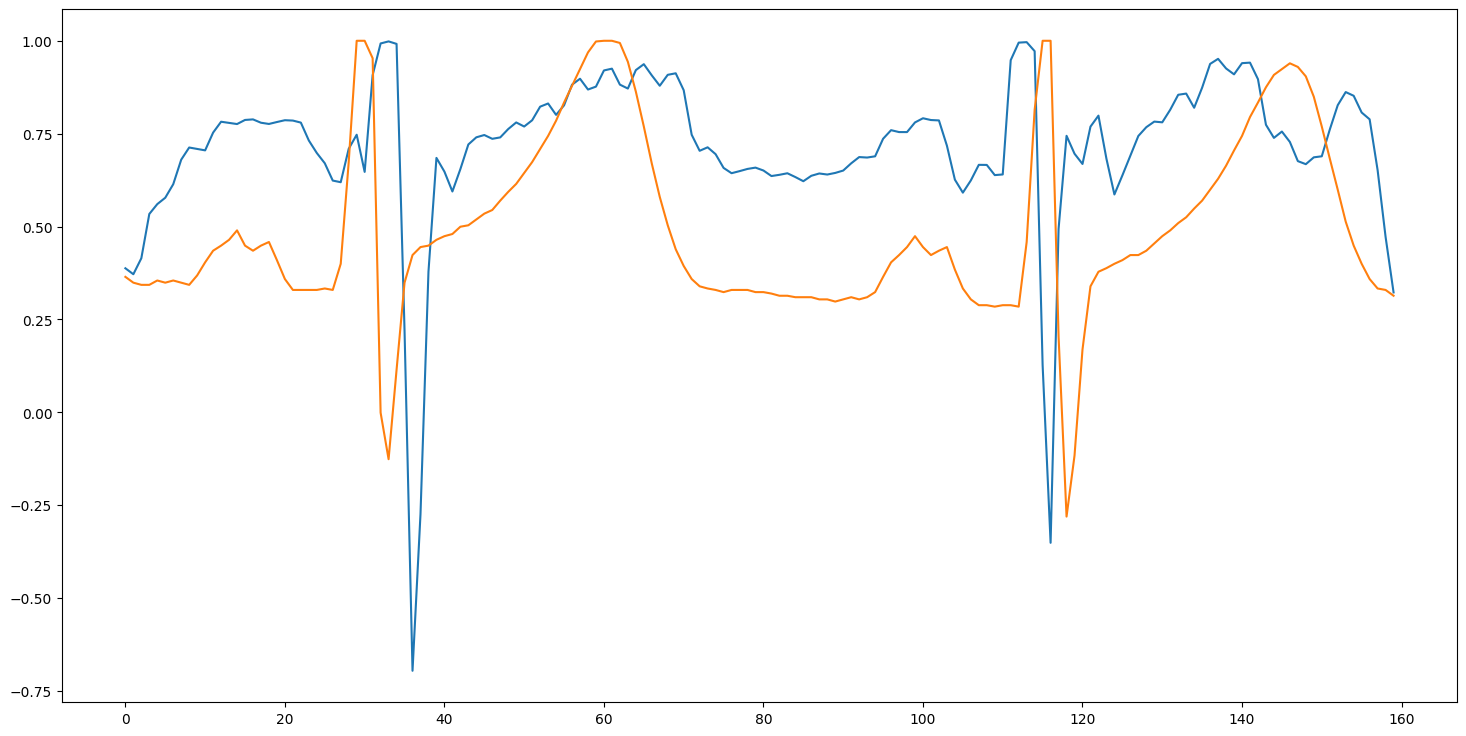

In [95]:
num_epochs = 100

window_size = 160

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

generator = GAN_Generator().to(device)
discriminator = GAN_Discriminator().to(device)
generator = generator.to(torch.float32).to(device)
discriminator = discriminator.to(torch.float32).to(device)
dataset = PPG2ECGDataset(PPG[:50000], ECG[:50000])
dataloader = DataLoader(dataset, batch_size=512)


# criterion = nn.MSELoss()
adversarial_loss = nn.BCELoss()
# lr = 10e-4
optimizer_G = optim.Adam(generator.parameters(), weight_decay=0.1)
optimizer_D = optim.Adam(discriminator.parameters(), weight_decay=0.1)

# schedular_G = optim.lr_schedular.StepLR(optimizer_G, step_size=10, gamma=0.1)
# schedular_D = optim.lr_schedular.StepLR(optimizer_D, step_size=10, gamma=0.1)

train_log = []

generator.train()
discriminator.train()
for epoch in range(num_epochs):
    # running_loss = 0
    for real_ppg, tgt, real_ecg in tqdm(dataloader):
        real_ppg = real_ppg.unsqueeze(1).to(device)
        real_ecg = real_ecg.unsqueeze(1).to(device)

        batch_size = real_ppg.shape[0]
        # print(batch_size)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train discriminator real
        optimizer_D.zero_grad()
        pred_real = discriminator(real_ecg, real_ppg)
        d_loss_real = adversarial_loss(pred_real, real_labels)
        # d_loss_real.backward()

        # Train discriminator fake
        fake_ecg = generator(real_ppg)
        pred_fake = discriminator(fake_ecg, real_ppg)
        d_loss_fake = adversarial_loss(pred_fake, fake_labels)
        # d_loss_fake.backward()

        d_loss = (d_loss_real + d_loss_fake) * 10 ## Update!!
        d_loss += calculate_wa_loss(discriminator, real_ecg, fake_ecg, real_ppg)
        d_loss.backward()
        optimizer_D.step()
        
        # Train generator
        optimizer_G.zero_grad()
        fake_ecg = generator(real_ppg)
        pred_fake = discriminator(fake_ecg, real_ppg)
        g_loss = adversarial_loss(pred_fake, real_labels)
        # peak_loss = get_peak_loss(fake_ecg, real_ecg)
        peak_loss = peak_alignment_loss(fake_ecg, real_ecg, height=0.3, distance=10)
        g_loss += combined_loss(fake_ecg, real_ecg)
        g_loss += peak_loss
        
        
        g_loss.backward()

        optimizer_G.step()

    # schedular_D.step()
    # schedular_G.step()
    print(f"Epoch {epoch}, d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")
    train_log.append(running_loss / len(dataset))

    with open(f"train_loss_gan_att_peakalign_03_10_epoch{epoch}.pkl", "wb") as f:
        pickle.dump(train_log, f)
    torch.save(generator.state_dict(), f"gan_generator_att_peakalign_03_10.pth")
    torch.save(discriminator.state_dict(), f"gan_discriminator_att_peakalign_03_10.pth")

# Test 
test_dataset = PPG2ECGDataset(PPG[50001:51000], ECG[50001:51000])
test_dataloader = DataLoader(test_dataset, batch_size=1)
# generator = GAN_Generator()
# generator = generator.to(torch.float32)
# generator.load_state_dict(torch.load("gan_generator_bceloss.pth", weights_only=True))
# criterion = nn.MSELoss()

test_log = []
out_lst = []
target_lst = []
device = "cpu"
generator.to(device)

for src, tgt, target in tqdm(test_dataloader):
    src = src.unsqueeze(1).to(device)
    # tgt = tgt.to(device)
    target = target.unsqueeze(1)
    target = target.to(device)
    out = generator(src)
    out = out.to(device)
    out_lst.append(out)
    target_lst.append(target)
    # loss = criterion(out, target)
    loss = combined_loss(out, target)
    test_log.append(loss.item())


out_lst_cpu = np.array([o.detach().to("cpu") for o in out_lst]).squeeze()
target_lst_cpu = np.array([t.detach().to("cpu") for t in target_lst]).squeeze()
# print(out_lst_cpu.shape)
# print(target_lst_cpu.shape)
plt.figure(figsize=(18, 9))

plt.plot(out_lst_cpu[0])
plt.plot(target_lst_cpu[0])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:44<00:00,  2.19it/s]


Epoch 0, d_loss: 1001.0, g_loss: 6.809762001037598


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:51<00:00,  1.91it/s]


Epoch 1, d_loss: 16.48542594909668, g_loss: 36.86119842529297


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 2, d_loss: 15.77658462524414, g_loss: 43.671600341796875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 3, d_loss: 13.740888595581055, g_loss: 591.082763671875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:47<00:00,  2.05it/s]


Epoch 4, d_loss: 14.389580726623535, g_loss: 474.72442626953125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:50<00:00,  1.93it/s]


Epoch 5, d_loss: 14.269393920898438, g_loss: 584.8609008789062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 6, d_loss: 14.288769721984863, g_loss: 570.9339599609375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:51<00:00,  1.91it/s]


Epoch 7, d_loss: 16.146438598632812, g_loss: 583.1921997070312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 8, d_loss: 14.729384422302246, g_loss: 546.478759765625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 9, d_loss: 10.371825218200684, g_loss: 584.485107421875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 10, d_loss: 30.995119094848633, g_loss: 4435.96484375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 11, d_loss: 1.823054552078247, g_loss: 34.30553436279297


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:50<00:00,  1.93it/s]


Epoch 12, d_loss: 3.299328565597534, g_loss: 550.8887939453125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.86it/s]


Epoch 13, d_loss: 8.018867492675781, g_loss: 663.4254760742188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:51<00:00,  1.92it/s]


Epoch 14, d_loss: 6.458502769470215, g_loss: 538.378173828125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:48<00:00,  2.01it/s]


Epoch 15, d_loss: 7.847259998321533, g_loss: 20.65781021118164


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 16, d_loss: 2.4262073040008545, g_loss: 34.090362548828125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 17, d_loss: 7.041885852813721, g_loss: 26.79807472229004


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 18, d_loss: 2.2639570236206055, g_loss: 63.99818420410156


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.81it/s]


Epoch 19, d_loss: 14.244491577148438, g_loss: 29.222116470336914


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 20, d_loss: 1.6495963335037231, g_loss: 49.00224304199219


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 21, d_loss: 7.72484827041626, g_loss: 26.45508575439453


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 22, d_loss: 1.7102041244506836, g_loss: 113.69506072998047


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 23, d_loss: 1.1559035778045654, g_loss: 52.169986724853516


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 24, d_loss: 4.640021324157715, g_loss: 57.71706008911133


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 25, d_loss: 5.93391227722168, g_loss: 26.945703506469727


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 26, d_loss: 7.477624893188477, g_loss: 82.49150848388672


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 27, d_loss: 4.714358806610107, g_loss: 179.36058044433594


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 28, d_loss: 5.283914089202881, g_loss: 29.495458602905273


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 29, d_loss: 8.488554000854492, g_loss: 22.346614837646484


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:51<00:00,  1.91it/s]


Epoch 30, d_loss: 1005.91845703125, g_loss: 7.534908294677734


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:47<00:00,  2.05it/s]


Epoch 31, d_loss: 2.8798325061798096, g_loss: 27.13642120361328


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 32, d_loss: 7.4482622146606445, g_loss: 33.900146484375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 33, d_loss: 13.806676864624023, g_loss: 23.530555725097656


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 34, d_loss: 8.833745002746582, g_loss: 37.470130920410156


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:48<00:00,  2.02it/s]


Epoch 35, d_loss: 1.1151851415634155, g_loss: 2137.658203125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:40<00:00,  2.43it/s]


Epoch 36, d_loss: 1.2343324422836304, g_loss: 2543.015869140625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:41<00:00,  2.36it/s]


Epoch 37, d_loss: 5.339669227600098, g_loss: 99.04902648925781


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 38, d_loss: 1.1287130117416382, g_loss: 21.646615982055664


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 39, d_loss: 12.782371520996094, g_loss: 55.51911544799805


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 40, d_loss: 7.078426837921143, g_loss: 21.09185028076172


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 41, d_loss: 9.990386009216309, g_loss: 30.40283203125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 42, d_loss: 6.079423904418945, g_loss: 30.94957160949707


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 43, d_loss: 3.1040685176849365, g_loss: 207.49734497070312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 44, d_loss: 10.124641418457031, g_loss: 19.309240341186523


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 45, d_loss: 13.649988174438477, g_loss: 3785.78271484375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 46, d_loss: 16.605403900146484, g_loss: 61.51309585571289


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 47, d_loss: 13.803476333618164, g_loss: 23.727127075195312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 48, d_loss: 10.239192962646484, g_loss: 80.07274627685547


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 49, d_loss: 1.1875457763671875, g_loss: 31.276525497436523


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.88it/s]


Epoch 50, d_loss: 0.8687382340431213, g_loss: 39.95160675048828


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.88it/s]


Epoch 51, d_loss: 1.0143508911132812, g_loss: 504.6588134765625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:42<00:00,  2.29it/s]


Epoch 52, d_loss: 1.053880214691162, g_loss: 553.2791137695312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:50<00:00,  1.93it/s]


Epoch 53, d_loss: 1.1133757829666138, g_loss: 2395.47216796875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 54, d_loss: 2.7590816020965576, g_loss: 545.43212890625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 55, d_loss: 1.9070230722427368, g_loss: 25.65250015258789


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 56, d_loss: 4.7275190353393555, g_loss: 293.02142333984375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 57, d_loss: 1.4954675436019897, g_loss: 188.14956665039062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 58, d_loss: 1.8301492929458618, g_loss: 159.91043090820312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.81it/s]


Epoch 59, d_loss: 4.054426193237305, g_loss: 24.666397094726562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 60, d_loss: 4.07928466796875, g_loss: 15.717048645019531


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 61, d_loss: 13.293272972106934, g_loss: 11.40484619140625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 62, d_loss: 0.8808140754699707, g_loss: 2134.196533203125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.87it/s]


Epoch 63, d_loss: 1.9617488384246826, g_loss: 13.274142265319824


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.87it/s]


Epoch 64, d_loss: 0.9161719083786011, g_loss: 547.7413330078125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 65, d_loss: 8.982566833496094, g_loss: 23.78260612487793


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 66, d_loss: 7.035426139831543, g_loss: 14.496063232421875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.88it/s]


Epoch 67, d_loss: 2.5156261920928955, g_loss: 20.910383224487305


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 68, d_loss: 6.498188495635986, g_loss: 19.399839401245117


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 69, d_loss: 5.877262115478516, g_loss: 20.009353637695312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 70, d_loss: 4.906655788421631, g_loss: 11.907451629638672


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 71, d_loss: 9.631549835205078, g_loss: 18.447797775268555


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 72, d_loss: 7.196369171142578, g_loss: 11.682534217834473


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 73, d_loss: 7.073007106781006, g_loss: 14.89145278930664


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 74, d_loss: 3.228644371032715, g_loss: 20.158218383789062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 75, d_loss: 4.9358744621276855, g_loss: 30.70633888244629


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 76, d_loss: 1.6310608386993408, g_loss: 163.33480834960938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 77, d_loss: 4.490838050842285, g_loss: 13.521435737609863


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 78, d_loss: 5.314043045043945, g_loss: 22.663225173950195


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 79, d_loss: 3.3562943935394287, g_loss: 15.098130226135254


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 80, d_loss: 2.4700517654418945, g_loss: 20.984804153442383


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 81, d_loss: 8.699573516845703, g_loss: 193.8290557861328


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 82, d_loss: 6.506768703460693, g_loss: 10.71886157989502


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 83, d_loss: 4.644530773162842, g_loss: 13.250651359558105


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 84, d_loss: 0.8808513879776001, g_loss: 2243.9482421875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 85, d_loss: 1.039070725440979, g_loss: 22.46949005126953


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:50<00:00,  1.94it/s]


Epoch 86, d_loss: 1.4241786003112793, g_loss: 188.8428497314453


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 87, d_loss: 0.9578574895858765, g_loss: 52.84030532836914


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 88, d_loss: 10.699402809143066, g_loss: 183.24122619628906


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 89, d_loss: 5.744846343994141, g_loss: 17.34014892578125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 90, d_loss: 6.580198287963867, g_loss: 17.51645851135254


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 91, d_loss: 4.1305251121521, g_loss: 592.8017578125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 92, d_loss: 4.2201738357543945, g_loss: 25.91675567626953


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 93, d_loss: 2.4209775924682617, g_loss: 21.392555236816406


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:51<00:00,  1.92it/s]


Epoch 94, d_loss: 1.7707598209381104, g_loss: 149.27969360351562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 95, d_loss: 1.6041061878204346, g_loss: 897.670654296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 96, d_loss: 1.1464481353759766, g_loss: 879.6493530273438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 97, d_loss: 0.8564183712005615, g_loss: 78.78731536865234


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:50<00:00,  1.93it/s]


Epoch 98, d_loss: 0.8125924468040466, g_loss: 209.22996520996094


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 99, d_loss: 2.3514528274536133, g_loss: 35.58451461791992


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 100, d_loss: 5.814887523651123, g_loss: 14.94653606414795


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 101, d_loss: 3.742252826690674, g_loss: 23.448814392089844


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 102, d_loss: 5.1372504234313965, g_loss: 22.306982040405273


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 103, d_loss: 4.7766876220703125, g_loss: 27.237260818481445


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 104, d_loss: 9.154179573059082, g_loss: 17.55613899230957


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 105, d_loss: 2.318089723587036, g_loss: 17.981082916259766


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 106, d_loss: 5.815321445465088, g_loss: 15.229686737060547


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 107, d_loss: 4.708359718322754, g_loss: 20.444217681884766


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 108, d_loss: 2.645078659057617, g_loss: 24.075761795043945


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 109, d_loss: 5.027931213378906, g_loss: 14.939680099487305


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 110, d_loss: 4.271356105804443, g_loss: 29.59737777709961


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:50<00:00,  1.92it/s]


Epoch 111, d_loss: 3.528909206390381, g_loss: 29.00320816040039


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 112, d_loss: 5.394432544708252, g_loss: 12.913063049316406


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 113, d_loss: 11.706225395202637, g_loss: 103.1756820678711


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 114, d_loss: 4.706016540527344, g_loss: 14.945760726928711


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 115, d_loss: 2.8179991245269775, g_loss: 16.772180557250977


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 116, d_loss: 3.4954464435577393, g_loss: 14.614459991455078


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:51<00:00,  1.90it/s]


Epoch 117, d_loss: 0.9820598363876343, g_loss: 303.0940856933594


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 118, d_loss: 83.19276428222656, g_loss: 28.31395149230957


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:41<00:00,  2.38it/s]


Epoch 119, d_loss: 1001.0, g_loss: 692.3934326171875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 120, d_loss: 1001.0, g_loss: 122.0698471069336


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 121, d_loss: 1001.0, g_loss: 114.79956817626953


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 122, d_loss: 1001.0, g_loss: 113.52934265136719


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 123, d_loss: 1001.0, g_loss: 116.90032196044922


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.81it/s]


Epoch 124, d_loss: 1001.0, g_loss: 117.88736724853516


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 125, d_loss: 1001.0, g_loss: 118.07679748535156


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 126, d_loss: 1001.0, g_loss: 118.39134216308594


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 127, d_loss: 1001.0, g_loss: 120.15745544433594


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 128, d_loss: 1001.0, g_loss: 126.87561798095703


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 129, d_loss: 1001.0, g_loss: 126.95770263671875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 130, d_loss: 1001.0, g_loss: 128.2554473876953


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.81it/s]


Epoch 131, d_loss: 1001.0, g_loss: 128.0498504638672


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 132, d_loss: 1001.0, g_loss: 126.21243286132812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 133, d_loss: 1001.0, g_loss: 127.58715057373047


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 134, d_loss: 1001.0, g_loss: 132.36373901367188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 135, d_loss: 1001.0, g_loss: 157.66683959960938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 136, d_loss: 1001.0, g_loss: 162.98805236816406


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.81it/s]


Epoch 137, d_loss: 1001.0, g_loss: 170.18264770507812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 138, d_loss: 1001.0, g_loss: 189.7041015625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 139, d_loss: 1001.0, g_loss: 222.16995239257812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 140, d_loss: 1001.0, g_loss: 271.1678771972656


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 141, d_loss: 1001.0, g_loss: 343.072998046875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 142, d_loss: 1001.0, g_loss: 358.1298828125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 143, d_loss: 1001.0, g_loss: 524.5601806640625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 144, d_loss: 1001.0, g_loss: 543.6594848632812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 145, d_loss: 1001.0, g_loss: 678.1078491210938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 146, d_loss: 1001.0, g_loss: 672.9708251953125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 147, d_loss: 1001.0, g_loss: 677.7229614257812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 148, d_loss: 1001.0, g_loss: 670.2992553710938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 149, d_loss: 1001.0, g_loss: 675.701904296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 150, d_loss: 1001.0, g_loss: 678.9037475585938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 151, d_loss: 1001.0, g_loss: 679.434326171875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 152, d_loss: 1001.0, g_loss: 678.6393432617188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 153, d_loss: 1001.0, g_loss: 666.595703125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 154, d_loss: 1001.0, g_loss: 666.5958251953125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 155, d_loss: 1001.0, g_loss: 666.6344604492188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 156, d_loss: 1001.0, g_loss: 666.5186157226562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 157, d_loss: 1001.0, g_loss: 666.5958251953125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 158, d_loss: 1001.0, g_loss: 666.6343994140625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 159, d_loss: 1001.0, g_loss: 666.6343994140625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 160, d_loss: 1001.0, g_loss: 666.6343383789062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 161, d_loss: 1001.0, g_loss: 666.63427734375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 162, d_loss: 1001.0, g_loss: 666.6342163085938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 163, d_loss: 1001.0, g_loss: 666.6341552734375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 164, d_loss: 1001.0, g_loss: 666.6341552734375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 165, d_loss: 1001.0, g_loss: 666.6341552734375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 166, d_loss: 1001.0, g_loss: 666.6340942382812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 167, d_loss: 1001.0, g_loss: 666.6340942382812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 168, d_loss: 1001.0, g_loss: 666.6341552734375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 169, d_loss: 1001.0, g_loss: 666.6341552734375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 170, d_loss: 1001.0, g_loss: 666.63427734375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 171, d_loss: 1001.0, g_loss: 666.6343383789062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 172, d_loss: 1001.0, g_loss: 666.6343994140625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 173, d_loss: 1001.0, g_loss: 666.634521484375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 174, d_loss: 1001.0, g_loss: 666.6346435546875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 175, d_loss: 1001.0, g_loss: 666.6348266601562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 176, d_loss: 1001.0, g_loss: 666.635009765625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 177, d_loss: 1001.0, g_loss: 666.6351928710938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 178, d_loss: 1001.0, g_loss: 666.6353759765625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 179, d_loss: 1001.0, g_loss: 666.6356201171875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 180, d_loss: 1001.0, g_loss: 666.635498046875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 181, d_loss: 1001.0, g_loss: 666.6361083984375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 182, d_loss: 1001.0, g_loss: 666.636474609375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 183, d_loss: 1001.0, g_loss: 666.6366577148438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 184, d_loss: 1001.0, g_loss: 666.6368408203125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 185, d_loss: 1001.0, g_loss: 666.6370849609375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 186, d_loss: 1001.0, g_loss: 666.6372680664062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 187, d_loss: 1001.0, g_loss: 666.6375122070312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 188, d_loss: 1001.0, g_loss: 666.6376953125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 189, d_loss: 1001.0, g_loss: 666.6378784179688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 190, d_loss: 1001.0, g_loss: 666.637939453125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 191, d_loss: 1001.0, g_loss: 666.637939453125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 192, d_loss: 1001.0, g_loss: 666.6385498046875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 193, d_loss: 1001.0, g_loss: 666.6390380859375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 194, d_loss: 1001.0, g_loss: 666.6388549804688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 195, d_loss: 1001.0, g_loss: 666.6390380859375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 196, d_loss: 1001.0, g_loss: 666.6390380859375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 197, d_loss: 1001.0, g_loss: 666.6390991210938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 198, d_loss: 1001.0, g_loss: 666.6392211914062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 199, d_loss: 1001.0, g_loss: 656.3960571289062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 200, d_loss: 939.265625, g_loss: 635.423828125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 201, d_loss: 677.2032470703125, g_loss: 617.5205078125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 202, d_loss: 1001.0, g_loss: 666.6430053710938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 203, d_loss: 1001.0, g_loss: 666.6182250976562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 204, d_loss: 1001.0, g_loss: 666.6217651367188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 205, d_loss: 1001.0, g_loss: 463.6499938964844


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 206, d_loss: 1001.0, g_loss: 464.70452880859375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 207, d_loss: 1001.0, g_loss: 147.41490173339844


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 208, d_loss: 1001.0, g_loss: 579.7044067382812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 209, d_loss: 1001.0, g_loss: 567.6441040039062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 210, d_loss: 1001.0, g_loss: 566.6181030273438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 211, d_loss: 1001.0, g_loss: 566.6193237304688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 212, d_loss: 1001.0, g_loss: 566.6201782226562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 213, d_loss: 1001.0, g_loss: 566.620849609375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 214, d_loss: 1001.0, g_loss: 566.6213989257812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 215, d_loss: 1001.0, g_loss: 566.6219482421875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 216, d_loss: 1001.0, g_loss: 566.6224365234375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 217, d_loss: 1001.0, g_loss: 566.6229858398438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 218, d_loss: 1001.0, g_loss: 566.62353515625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 219, d_loss: 1001.0, g_loss: 566.6241455078125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 220, d_loss: 1001.0, g_loss: 566.6246948242188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 221, d_loss: 1001.0, g_loss: 566.6253051757812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 222, d_loss: 1001.0, g_loss: 566.6259155273438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 223, d_loss: 1001.0, g_loss: 566.6265258789062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 224, d_loss: 1001.0, g_loss: 566.6271362304688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 225, d_loss: 1001.0, g_loss: 566.6277465820312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 226, d_loss: 1001.0, g_loss: 486.7363586425781


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 227, d_loss: 1001.0, g_loss: 463.6190185546875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.81it/s]


Epoch 228, d_loss: 1113.994384765625, g_loss: 526.9338989257812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 229, d_loss: 1029.24853515625, g_loss: 535.8184814453125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 230, d_loss: 1029.24853515625, g_loss: 537.7691650390625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 231, d_loss: 1029.24853515625, g_loss: 534.0537719726562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 232, d_loss: 1023.598876953125, g_loss: 503.61676025390625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 233, d_loss: 1023.598876953125, g_loss: 178.79385375976562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 234, d_loss: 1017.9491577148438, g_loss: 704.1053466796875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 235, d_loss: 1017.9491577148438, g_loss: 663.2210693359375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 236, d_loss: 1017.9491577148438, g_loss: 652.3953857421875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 237, d_loss: 1017.9491577148438, g_loss: 651.3342895507812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 238, d_loss: 1017.9491577148438, g_loss: 650.9231567382812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 239, d_loss: 1017.9491577148438, g_loss: 643.0623168945312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 240, d_loss: 1017.9491577148438, g_loss: 637.7123413085938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 241, d_loss: 1012.2994384765625, g_loss: 638.2783203125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 242, d_loss: 1012.2994384765625, g_loss: 638.2791748046875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 243, d_loss: 1006.6497192382812, g_loss: 638.8449096679688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 244, d_loss: 1017.9491577148438, g_loss: 637.715576171875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 245, d_loss: 1006.6497192382812, g_loss: 637.2533569335938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 246, d_loss: 1001.0, g_loss: 637.8187866210938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 247, d_loss: 1001.0, g_loss: 637.8191528320312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 248, d_loss: 1012.2994384765625, g_loss: 636.7147216796875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 249, d_loss: 1012.2994384765625, g_loss: 636.6983642578125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 250, d_loss: 1012.2994384765625, g_loss: 636.697021484375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 251, d_loss: 1012.2994384765625, g_loss: 636.6941528320312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 252, d_loss: 1012.2994384765625, g_loss: 636.6947631835938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 253, d_loss: 1012.2994384765625, g_loss: 636.6943969726562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 254, d_loss: 1006.6497192382812, g_loss: 637.2604370117188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 255, d_loss: 1012.2994384765625, g_loss: 636.6943359375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 256, d_loss: 1015.21240234375, g_loss: 636.6934204101562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 257, d_loss: 1015.2322998046875, g_loss: 636.6939086914062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 258, d_loss: 1015.2322387695312, g_loss: 636.6940307617188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 259, d_loss: 1015.2294921875, g_loss: 636.69482421875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 260, d_loss: 1014.6593017578125, g_loss: 636.6943359375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 261, d_loss: 1003.3343505859375, g_loss: 637.8245849609375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 262, d_loss: 1006.6497192382812, g_loss: 637.8245849609375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 263, d_loss: 1006.6497192382812, g_loss: 637.8240356445312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 264, d_loss: 1012.2994384765625, g_loss: 637.2588500976562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 265, d_loss: 1012.2994384765625, g_loss: 637.2589111328125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 266, d_loss: 1012.2994384765625, g_loss: 637.259033203125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 267, d_loss: 1017.9491577148438, g_loss: 636.694091796875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 268, d_loss: 1017.9491577148438, g_loss: 636.6942138671875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 269, d_loss: 1017.9491577148438, g_loss: 636.6942749023438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 270, d_loss: 1017.9491577148438, g_loss: 636.6934204101562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 271, d_loss: 1017.9491577148438, g_loss: 636.6941528320312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 272, d_loss: 1017.9491577148438, g_loss: 636.6934814453125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 273, d_loss: 1017.9491577148438, g_loss: 636.6943969726562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 274, d_loss: 1012.2994384765625, g_loss: 636.6947631835938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 275, d_loss: 1017.9491577148438, g_loss: 636.6943969726562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 276, d_loss: 1017.9491577148438, g_loss: 636.6945190429688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 277, d_loss: 1017.9491577148438, g_loss: 636.6945190429688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 278, d_loss: 1017.9491577148438, g_loss: 636.6943969726562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 279, d_loss: 1017.9491577148438, g_loss: 636.6945190429688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 280, d_loss: 1017.9491577148438, g_loss: 636.6942138671875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 281, d_loss: 1017.9491577148438, g_loss: 636.6951904296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 282, d_loss: 1017.9491577148438, g_loss: 636.6947631835938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 283, d_loss: 1017.9491577148438, g_loss: 636.695068359375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 284, d_loss: 1017.9491577148438, g_loss: 636.695068359375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 285, d_loss: 1017.9491577148438, g_loss: 636.6951904296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 286, d_loss: 1017.9491577148438, g_loss: 636.6953735351562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 287, d_loss: 1017.9491577148438, g_loss: 636.69580078125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 288, d_loss: 1017.9491577148438, g_loss: 636.6959228515625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 289, d_loss: 1017.9491577148438, g_loss: 636.6954956054688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 290, d_loss: 1017.9491577148438, g_loss: 636.6953125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 291, d_loss: 1017.9491577148438, g_loss: 636.6956787109375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 292, d_loss: 1012.2994384765625, g_loss: 637.8252563476562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 293, d_loss: 1012.2994384765625, g_loss: 637.2611083984375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 294, d_loss: 1012.2994384765625, g_loss: 637.2609252929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 295, d_loss: 1012.2994384765625, g_loss: 637.2603759765625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 296, d_loss: 1006.6497192382812, g_loss: 637.8255004882812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 297, d_loss: 1012.2994384765625, g_loss: 637.82666015625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 298, d_loss: 1017.9491577148438, g_loss: 637.2608642578125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 299, d_loss: 1017.9491577148438, g_loss: 637.2612915039062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 300, d_loss: 1017.9491577148438, g_loss: 637.2608642578125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 301, d_loss: 1017.9491577148438, g_loss: 637.260986328125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 302, d_loss: 1017.9491577148438, g_loss: 637.2608032226562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 303, d_loss: 1017.9491577148438, g_loss: 637.2608642578125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 304, d_loss: 1017.9491577148438, g_loss: 637.26123046875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 305, d_loss: 1017.9491577148438, g_loss: 637.2609252929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 306, d_loss: 1017.9491577148438, g_loss: 637.2611083984375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 307, d_loss: 1017.9491577148438, g_loss: 637.260986328125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 308, d_loss: 1017.9491577148438, g_loss: 637.26123046875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 309, d_loss: 1017.9491577148438, g_loss: 637.2611694335938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 310, d_loss: 1017.9491577148438, g_loss: 637.2610473632812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 311, d_loss: 1017.9491577148438, g_loss: 637.2610473632812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 312, d_loss: 1017.9491577148438, g_loss: 637.2611083984375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 313, d_loss: 1017.9491577148438, g_loss: 637.260986328125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 314, d_loss: 1017.9491577148438, g_loss: 637.2611694335938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 315, d_loss: 1017.9491577148438, g_loss: 637.2610473632812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 316, d_loss: 1017.9491577148438, g_loss: 637.2611083984375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 317, d_loss: 1125.2938232421875, g_loss: 524.7166137695312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 318, d_loss: 1063.14697265625, g_loss: 531.4231567382812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 319, d_loss: 1040.548095703125, g_loss: 533.7666625976562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 320, d_loss: 1057.4971923828125, g_loss: 633.1578979492188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 321, d_loss: 1034.8983154296875, g_loss: 635.43115234375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 322, d_loss: 1034.8983154296875, g_loss: 636.007080078125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 323, d_loss: 1034.8983154296875, g_loss: 636.0161743164062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 324, d_loss: 1046.19775390625, g_loss: 634.3286743164062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 325, d_loss: 1046.19775390625, g_loss: 634.3347778320312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 326, d_loss: 1051.847412109375, g_loss: 634.3397827148438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 327, d_loss: 1046.19775390625, g_loss: 634.343994140625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 328, d_loss: 1040.548095703125, g_loss: 634.3475341796875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 329, d_loss: 1040.548095703125, g_loss: 634.3505859375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 330, d_loss: 1029.24853515625, g_loss: 634.9183349609375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 331, d_loss: 1023.598876953125, g_loss: 634.920654296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 332, d_loss: 1023.598876953125, g_loss: 634.9228515625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 333, d_loss: 1012.2994384765625, g_loss: 635.4898071289062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 334, d_loss: 1006.6497192382812, g_loss: 636.0626220703125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 335, d_loss: 1006.6497192382812, g_loss: 636.0634765625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 336, d_loss: 1006.6497192382812, g_loss: 638.2179565429688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 337, d_loss: 1001.0, g_loss: 636.0706787109375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 338, d_loss: 1001.0, g_loss: 636.0717163085938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 339, d_loss: 989.7005615234375, g_loss: 649.632080078125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 340, d_loss: 989.7005615234375, g_loss: 649.6332397460938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 341, d_loss: 989.7005615234375, g_loss: 649.6343994140625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 342, d_loss: 989.7005615234375, g_loss: 650.663330078125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 343, d_loss: 989.7005615234375, g_loss: 649.6368408203125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 344, d_loss: 995.3502807617188, g_loss: 655.4520263671875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.81it/s]


Epoch 345, d_loss: 995.3502807617188, g_loss: 650.1021728515625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 346, d_loss: 995.3502807617188, g_loss: 650.1034545898438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 347, d_loss: 1001.0, g_loss: 649.0770263671875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 348, d_loss: 1001.0, g_loss: 650.1061401367188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 349, d_loss: 1001.0, g_loss: 650.0498657226562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 350, d_loss: 1001.0, g_loss: 657.5294189453125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 351, d_loss: 995.3502807617188, g_loss: 650.3331298828125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 352, d_loss: 995.3502807617188, g_loss: 662.8751220703125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 353, d_loss: 995.3502807617188, g_loss: 660.6597900390625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 354, d_loss: 995.3502807617188, g_loss: 648.43798828125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 355, d_loss: 995.3502807617188, g_loss: 656.5709228515625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 356, d_loss: 1001.0, g_loss: 672.0328369140625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 357, d_loss: 1001.0, g_loss: 653.54931640625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 358, d_loss: 1006.6497192382812, g_loss: 669.78125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 359, d_loss: 1006.6497192382812, g_loss: 672.4339599609375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 360, d_loss: 1006.6497192382812, g_loss: 660.1216430664062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 361, d_loss: 1006.6497192382812, g_loss: 669.6588134765625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 362, d_loss: 1006.6497192382812, g_loss: 665.6387939453125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 363, d_loss: 1001.0, g_loss: 670.6449584960938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 364, d_loss: 1006.6497192382812, g_loss: 663.056884765625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 365, d_loss: 1001.0, g_loss: 664.99560546875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 366, d_loss: 1006.6497192382812, g_loss: 677.0338745117188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 367, d_loss: 1006.6497192382812, g_loss: 680.3062744140625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 368, d_loss: 1006.6497192382812, g_loss: 668.6502685546875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 369, d_loss: 1006.6497192382812, g_loss: 701.49755859375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 370, d_loss: 1006.6497192382812, g_loss: 718.2160034179688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 371, d_loss: 1012.2994384765625, g_loss: 679.9700927734375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 372, d_loss: 1006.6497192382812, g_loss: 663.6890258789062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 373, d_loss: 1006.6497192382812, g_loss: 563.9564208984375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 374, d_loss: 1006.6497192382812, g_loss: 667.0556030273438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 375, d_loss: 1017.9491577148438, g_loss: 661.5430297851562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 376, d_loss: 1017.9491577148438, g_loss: 668.498291015625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 377, d_loss: 1017.9491577148438, g_loss: 674.0136108398438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 378, d_loss: 1017.9491577148438, g_loss: 668.5934448242188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 379, d_loss: 1017.9491577148438, g_loss: 653.53759765625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 380, d_loss: 1012.2994384765625, g_loss: 653.5383911132812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 381, d_loss: 1012.2994384765625, g_loss: 652.5111083984375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 382, d_loss: 1017.9491577148438, g_loss: 651.9466552734375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 383, d_loss: 1017.9491577148438, g_loss: 652.9749145507812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 384, d_loss: 1017.9491577148438, g_loss: 651.8800659179688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 385, d_loss: 1017.9491577148438, g_loss: 651.892333984375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 386, d_loss: 1012.2994384765625, g_loss: 551.289794921875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 387, d_loss: 1012.2994384765625, g_loss: 651.8545532226562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 388, d_loss: 1006.6497192382812, g_loss: 554.0432739257812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 389, d_loss: 1001.0, g_loss: 665.45068359375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 390, d_loss: 1001.0, g_loss: 652.3720703125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 391, d_loss: 1001.0, g_loss: 652.3825073242188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 392, d_loss: 1001.0, g_loss: 652.3922119140625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 393, d_loss: 1001.0, g_loss: 652.401611328125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 394, d_loss: 1001.0, g_loss: 653.4385375976562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 395, d_loss: 1006.6497192382812, g_loss: 666.9945068359375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 396, d_loss: 1006.6497192382812, g_loss: 666.5809326171875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 397, d_loss: 1006.6497192382812, g_loss: 660.342041015625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 398, d_loss: 1006.6497192382812, g_loss: 687.258544921875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 399, d_loss: 1006.6497192382812, g_loss: 669.8212280273438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 400, d_loss: 1001.0, g_loss: 685.4326782226562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 401, d_loss: 1001.0, g_loss: 687.7215576171875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 402, d_loss: 1001.0, g_loss: 691.8051147460938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 403, d_loss: 1001.0, g_loss: 233.83163452148438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 404, d_loss: 1001.0, g_loss: 595.5391235351562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 405, d_loss: 995.3502807617188, g_loss: 262.58673095703125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 406, d_loss: 995.3502807617188, g_loss: 830.4970703125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.88it/s]


Epoch 407, d_loss: 995.3502807617188, g_loss: 2080.65087890625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.87it/s]


Epoch 408, d_loss: 995.3502807617188, g_loss: 346.99835205078125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 409, d_loss: 995.3502807617188, g_loss: 665.4561767578125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 410, d_loss: 989.7005615234375, g_loss: 658.3621826171875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 411, d_loss: 989.7005615234375, g_loss: 655.6072998046875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 412, d_loss: 989.7005615234375, g_loss: 653.5350952148438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 413, d_loss: 989.7005615234375, g_loss: 659.4395751953125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 414, d_loss: 989.7005615234375, g_loss: 654.1025390625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 415, d_loss: 989.7005615234375, g_loss: 653.0758666992188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 416, d_loss: 984.0508422851562, g_loss: 654.1043701171875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 417, d_loss: 984.0508422851562, g_loss: 653.0772094726562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 418, d_loss: 984.0508422851562, g_loss: 653.0778198242188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 419, d_loss: 984.0508422851562, g_loss: 654.1058349609375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 420, d_loss: 984.0508422851562, g_loss: 653.0780639648438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 421, d_loss: 984.0508422851562, g_loss: 654.1063842773438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 422, d_loss: 995.3502807617188, g_loss: 660.5880737304688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 423, d_loss: 995.3502807617188, g_loss: 654.2086791992188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 424, d_loss: 995.3502807617188, g_loss: 655.23681640625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 425, d_loss: 989.7005615234375, g_loss: 655.2369384765625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 426, d_loss: 989.7005615234375, g_loss: 659.7493286132812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 427, d_loss: 989.7005615234375, g_loss: 655.23681640625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 428, d_loss: 989.7005615234375, g_loss: 654.2088623046875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 429, d_loss: 989.7005615234375, g_loss: 654.2088623046875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 430, d_loss: 989.7005615234375, g_loss: 654.208984375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 431, d_loss: 989.7005615234375, g_loss: 654.2091674804688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 432, d_loss: 989.7005615234375, g_loss: 654.209228515625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 433, d_loss: 989.7005615234375, g_loss: 654.209228515625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 434, d_loss: 989.7005615234375, g_loss: 654.208740234375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 435, d_loss: 989.7005615234375, g_loss: 654.2098999023438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 436, d_loss: 989.7005615234375, g_loss: 654.2096557617188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 437, d_loss: 989.7005615234375, g_loss: 654.2093505859375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 438, d_loss: 989.7005615234375, g_loss: 654.2095336914062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 439, d_loss: 984.0508422851562, g_loss: 654.2098999023438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 440, d_loss: 984.0508422851562, g_loss: 654.2096557617188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 441, d_loss: 984.0508422851562, g_loss: 654.209716796875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 442, d_loss: 984.0508422851562, g_loss: 654.2093505859375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 443, d_loss: 984.0508422851562, g_loss: 654.2103271484375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 444, d_loss: 984.0508422851562, g_loss: 654.2098999023438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 445, d_loss: 984.0508422851562, g_loss: 654.2099609375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 446, d_loss: 984.0508422851562, g_loss: 654.209716796875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 447, d_loss: 984.0508422851562, g_loss: 654.2096557617188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 448, d_loss: 984.0508422851562, g_loss: 654.2097778320312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 449, d_loss: 984.0508422851562, g_loss: 654.2098999023438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 450, d_loss: 984.0508422851562, g_loss: 654.209228515625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 451, d_loss: 984.0508422851562, g_loss: 654.2109375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 452, d_loss: 984.0508422851562, g_loss: 654.2099609375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 453, d_loss: 984.0508422851562, g_loss: 654.2098999023438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 454, d_loss: 984.0508422851562, g_loss: 654.2100830078125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 455, d_loss: 984.0508422851562, g_loss: 654.2100219726562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 456, d_loss: 984.0508422851562, g_loss: 654.2098388671875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 457, d_loss: 972.7514038085938, g_loss: 651.38525390625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 458, d_loss: 1091.3955078125, g_loss: 633.8704223632812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 459, d_loss: 1091.3955078125, g_loss: 633.8717041015625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 460, d_loss: 1091.3955078125, g_loss: 633.870849609375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 461, d_loss: 1097.045166015625, g_loss: 633.3059692382812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 462, d_loss: 1097.045166015625, g_loss: 633.3060913085938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 463, d_loss: 1097.045166015625, g_loss: 633.30615234375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 464, d_loss: 1097.045166015625, g_loss: 633.305908203125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 465, d_loss: 1097.045166015625, g_loss: 633.3060913085938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 466, d_loss: 1097.045166015625, g_loss: 633.3062744140625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 467, d_loss: 1097.045166015625, g_loss: 633.3060913085938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 468, d_loss: 1097.045166015625, g_loss: 633.30615234375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 469, d_loss: 1102.6949462890625, g_loss: 632.7412109375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 470, d_loss: 1102.6949462890625, g_loss: 632.7411499023438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 471, d_loss: 1102.6949462890625, g_loss: 632.7410888671875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 472, d_loss: 1102.6949462890625, g_loss: 632.7411499023438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 473, d_loss: 1102.6949462890625, g_loss: 632.7411499023438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 474, d_loss: 1102.6949462890625, g_loss: 632.7413330078125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 475, d_loss: 1102.6949462890625, g_loss: 632.7412109375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 476, d_loss: 1102.6949462890625, g_loss: 632.7412719726562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 477, d_loss: 1102.6949462890625, g_loss: 632.7412109375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 478, d_loss: 1102.6949462890625, g_loss: 632.7410888671875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 479, d_loss: 1102.6949462890625, g_loss: 632.740966796875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.86it/s]


Epoch 480, d_loss: 1102.6949462890625, g_loss: 632.741455078125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 481, d_loss: 1102.6949462890625, g_loss: 632.7412109375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 482, d_loss: 1097.045166015625, g_loss: 632.7411499023438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 483, d_loss: 1097.045166015625, g_loss: 632.7412109375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 484, d_loss: 1091.3955078125, g_loss: 633.3135986328125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 485, d_loss: 1097.045166015625, g_loss: 632.7388305664062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 486, d_loss: 1097.045166015625, g_loss: 632.7418823242188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 487, d_loss: 1097.045166015625, g_loss: 632.7413330078125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 488, d_loss: 1097.045166015625, g_loss: 632.741455078125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 489, d_loss: 1097.045166015625, g_loss: 632.74169921875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 490, d_loss: 1097.045166015625, g_loss: 632.7415771484375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 491, d_loss: 1097.045166015625, g_loss: 632.7412109375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 492, d_loss: 1097.045166015625, g_loss: 632.7415161132812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 493, d_loss: 1097.045166015625, g_loss: 632.741455078125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 494, d_loss: 1097.045166015625, g_loss: 632.7413330078125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 495, d_loss: 1102.6949462890625, g_loss: 632.17626953125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 496, d_loss: 1130.943603515625, g_loss: 559.325927734375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 497, d_loss: 1080.0960693359375, g_loss: 634.4677734375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 498, d_loss: 1080.0960693359375, g_loss: 634.4388427734375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 499, d_loss: 1085.745849609375, g_loss: 633.8703002929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 500, d_loss: 1085.745849609375, g_loss: 633.8638305664062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 501, d_loss: 1085.745849609375, g_loss: 633.8614501953125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 502, d_loss: 1085.745849609375, g_loss: 633.8600463867188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 503, d_loss: 1085.745849609375, g_loss: 633.8592529296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 504, d_loss: 1085.745849609375, g_loss: 633.8587646484375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 505, d_loss: 1085.745849609375, g_loss: 633.8585815429688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 506, d_loss: 1085.745849609375, g_loss: 633.8584594726562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 507, d_loss: 1085.745849609375, g_loss: 633.8584594726562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 508, d_loss: 1085.745849609375, g_loss: 633.8585205078125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 509, d_loss: 1080.0960693359375, g_loss: 634.423583984375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 510, d_loss: 1080.0960693359375, g_loss: 634.4237060546875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 511, d_loss: 1080.0960693359375, g_loss: 634.4238891601562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 512, d_loss: 1074.4462890625, g_loss: 634.424072265625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 513, d_loss: 1074.4462890625, g_loss: 634.4242553710938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 514, d_loss: 1068.796630859375, g_loss: 634.4244995117188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 515, d_loss: 1068.796630859375, g_loss: 634.4247436523438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 516, d_loss: 1068.796630859375, g_loss: 634.4249267578125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 517, d_loss: 1068.796630859375, g_loss: 634.4251708984375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 518, d_loss: 1068.796630859375, g_loss: 634.4254150390625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 519, d_loss: 1068.796630859375, g_loss: 634.42578125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 520, d_loss: 1068.796630859375, g_loss: 634.4259643554688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 521, d_loss: 1068.796630859375, g_loss: 634.4262084960938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 522, d_loss: 1068.796630859375, g_loss: 634.4265747070312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 523, d_loss: 1068.796630859375, g_loss: 634.4268798828125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 524, d_loss: 1068.796630859375, g_loss: 634.4271240234375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 525, d_loss: 1063.14697265625, g_loss: 634.9923095703125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 526, d_loss: 1057.4971923828125, g_loss: 635.5575561523438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 527, d_loss: 1063.14697265625, g_loss: 634.992919921875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 528, d_loss: 1057.4971923828125, g_loss: 635.5579833984375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 529, d_loss: 1063.14697265625, g_loss: 634.993896484375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 530, d_loss: 1063.14697265625, g_loss: 634.9940185546875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 531, d_loss: 1068.796630859375, g_loss: 634.4292602539062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 532, d_loss: 1068.796630859375, g_loss: 634.4293212890625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 533, d_loss: 1057.4971923828125, g_loss: 634.4301147460938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 534, d_loss: 1051.847412109375, g_loss: 634.4302368164062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 535, d_loss: 1046.19775390625, g_loss: 634.995361328125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 536, d_loss: 1040.548095703125, g_loss: 634.99560546875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 537, d_loss: 1040.548095703125, g_loss: 634.9959106445312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 538, d_loss: 1040.548095703125, g_loss: 634.9961547851562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 539, d_loss: 1040.548095703125, g_loss: 634.9963989257812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 540, d_loss: 1040.548095703125, g_loss: 634.9967041015625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 541, d_loss: 1040.548095703125, g_loss: 634.9969482421875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 542, d_loss: 1040.548095703125, g_loss: 634.9971313476562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 543, d_loss: 1029.24853515625, g_loss: 634.997314453125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 544, d_loss: 1029.24853515625, g_loss: 634.9974975585938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 545, d_loss: 1029.24853515625, g_loss: 634.9977416992188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 546, d_loss: 1034.8983154296875, g_loss: 634.4329223632812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 547, d_loss: 1034.8983154296875, g_loss: 634.43310546875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 548, d_loss: 1029.24853515625, g_loss: 634.4334106445312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 549, d_loss: 1023.598876953125, g_loss: 634.99853515625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 550, d_loss: 1012.2994384765625, g_loss: 634.9987182617188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 551, d_loss: 1012.2994384765625, g_loss: 634.998779296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.81it/s]


Epoch 552, d_loss: 1001.0, g_loss: 635.5639038085938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 553, d_loss: 1001.0, g_loss: 635.5640258789062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 554, d_loss: 1001.0, g_loss: 635.5642700195312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 555, d_loss: 989.7005615234375, g_loss: 635.564208984375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 556, d_loss: 984.0508422851562, g_loss: 636.1295776367188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 557, d_loss: 978.401123046875, g_loss: 636.129638671875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 558, d_loss: 1080.0960693359375, g_loss: 625.3953247070312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 559, d_loss: 1164.841796875, g_loss: 606.7313232421875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 560, d_loss: 1164.841796875, g_loss: 606.7415771484375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 561, d_loss: 1159.192138671875, g_loss: 607.3115234375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 562, d_loss: 1159.192138671875, g_loss: 608.3416748046875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 563, d_loss: 1159.192138671875, g_loss: 607.315185546875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 564, d_loss: 1159.192138671875, g_loss: 608.343505859375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 565, d_loss: 1159.192138671875, g_loss: 607.3160400390625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 566, d_loss: 1159.192138671875, g_loss: 608.3441772460938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 567, d_loss: 1159.192138671875, g_loss: 607.3165283203125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 568, d_loss: 1147.8927001953125, g_loss: 607.8818359375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 569, d_loss: 1147.8927001953125, g_loss: 607.8809204101562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 570, d_loss: 1142.242919921875, g_loss: 608.4464111328125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 571, d_loss: 1142.242919921875, g_loss: 609.4741821289062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 572, d_loss: 1136.59326171875, g_loss: 609.0125122070312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 573, d_loss: 1136.59326171875, g_loss: 609.012451171875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 574, d_loss: 1136.59326171875, g_loss: 610.0402221679688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 575, d_loss: 1136.59326171875, g_loss: 609.0123291015625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 576, d_loss: 1136.59326171875, g_loss: 609.0125732421875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 577, d_loss: 1136.59326171875, g_loss: 610.0403442382812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 578, d_loss: 1136.59326171875, g_loss: 609.012451171875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 579, d_loss: 1136.59326171875, g_loss: 609.0126342773438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 580, d_loss: 1130.943603515625, g_loss: 609.5775146484375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 581, d_loss: 1125.2938232421875, g_loss: 610.1425170898438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 582, d_loss: 1125.2938232421875, g_loss: 610.1423950195312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 583, d_loss: 1130.943603515625, g_loss: 610.1426391601562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 584, d_loss: 1130.943603515625, g_loss: 610.142578125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 585, d_loss: 1130.943603515625, g_loss: 610.1427612304688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 586, d_loss: 1130.943603515625, g_loss: 610.142578125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 587, d_loss: 1130.943603515625, g_loss: 610.1427001953125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 588, d_loss: 1130.943603515625, g_loss: 610.1427001953125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 589, d_loss: 1130.943603515625, g_loss: 610.1425170898438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 590, d_loss: 1130.943603515625, g_loss: 610.1427001953125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 591, d_loss: 1130.943603515625, g_loss: 610.142578125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 592, d_loss: 1130.943603515625, g_loss: 610.1425170898438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 593, d_loss: 1136.59326171875, g_loss: 610.1427001953125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 594, d_loss: 1136.59326171875, g_loss: 610.1426391601562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 595, d_loss: 1136.59326171875, g_loss: 610.1425170898438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 596, d_loss: 1142.242919921875, g_loss: 609.5775146484375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 597, d_loss: 1142.242919921875, g_loss: 609.577392578125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 598, d_loss: 1142.242919921875, g_loss: 609.5776977539062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 599, d_loss: 1142.242919921875, g_loss: 609.5776977539062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 600, d_loss: 1136.59326171875, g_loss: 609.57763671875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 601, d_loss: 1142.242919921875, g_loss: 609.0126953125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 602, d_loss: 1142.242919921875, g_loss: 609.0125122070312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 603, d_loss: 1142.242919921875, g_loss: 609.0123901367188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 604, d_loss: 1164.841796875, g_loss: 607.9136962890625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 605, d_loss: 1153.54248046875, g_loss: 616.1318359375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 606, d_loss: 1164.841796875, g_loss: 608.0125732421875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 607, d_loss: 1164.841796875, g_loss: 607.495361328125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 608, d_loss: 1164.841796875, g_loss: 607.5076904296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 609, d_loss: 1159.192138671875, g_loss: 608.0821533203125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 610, d_loss: 1153.54248046875, g_loss: 608.6549072265625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 611, d_loss: 1147.8927001953125, g_loss: 609.2264404296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 612, d_loss: 1147.8927001953125, g_loss: 609.2320556640625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 613, d_loss: 1147.8927001953125, g_loss: 608.414306640625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 614, d_loss: 1147.8927001953125, g_loss: 608.418701171875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 615, d_loss: 1147.8927001953125, g_loss: 608.4225463867188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 616, d_loss: 1147.8927001953125, g_loss: 608.4259643554688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 617, d_loss: 1147.8927001953125, g_loss: 608.428955078125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 618, d_loss: 1147.8927001953125, g_loss: 608.4315795898438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 619, d_loss: 1153.54248046875, g_loss: 607.8688354492188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 620, d_loss: 1147.8927001953125, g_loss: 607.8707885742188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 621, d_loss: 1153.54248046875, g_loss: 607.8724365234375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 622, d_loss: 1153.54248046875, g_loss: 607.8738403320312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 623, d_loss: 1153.54248046875, g_loss: 607.8753051757812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 624, d_loss: 1153.54248046875, g_loss: 607.3114013671875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 625, d_loss: 1153.54248046875, g_loss: 607.3121948242188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 626, d_loss: 1159.192138671875, g_loss: 607.3126831054688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 627, d_loss: 1159.192138671875, g_loss: 607.313232421875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 628, d_loss: 1159.192138671875, g_loss: 607.3137817382812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 629, d_loss: 1159.192138671875, g_loss: 607.31396484375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 630, d_loss: 1159.192138671875, g_loss: 607.3148193359375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 631, d_loss: 1159.192138671875, g_loss: 607.3150634765625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 632, d_loss: 1159.192138671875, g_loss: 607.3161010742188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 633, d_loss: 1159.192138671875, g_loss: 607.3158569335938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 634, d_loss: 1159.192138671875, g_loss: 607.3160400390625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 635, d_loss: 1159.192138671875, g_loss: 607.3161010742188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 636, d_loss: 1159.192138671875, g_loss: 607.316650390625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 637, d_loss: 1153.54248046875, g_loss: 607.881591796875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 638, d_loss: 1153.54248046875, g_loss: 607.8817749023438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 639, d_loss: 1153.54248046875, g_loss: 607.881591796875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 640, d_loss: 1153.54248046875, g_loss: 607.8815307617188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 641, d_loss: 1153.54248046875, g_loss: 607.8807983398438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 642, d_loss: 1147.8927001953125, g_loss: 608.446533203125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 643, d_loss: 1153.5423583984375, g_loss: 608.4466552734375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 644, d_loss: 1153.5423583984375, g_loss: 608.446533203125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 645, d_loss: 1153.5423583984375, g_loss: 608.446533203125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 646, d_loss: 1153.5423583984375, g_loss: 608.446533203125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 647, d_loss: 1153.5423583984375, g_loss: 608.44580078125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 648, d_loss: 1153.5423583984375, g_loss: 608.4473266601562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 649, d_loss: 1153.5423583984375, g_loss: 608.447021484375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 650, d_loss: 1153.5423583984375, g_loss: 608.44677734375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 651, d_loss: 1147.892578125, g_loss: 609.0118408203125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 652, d_loss: 1147.892578125, g_loss: 609.011474609375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 653, d_loss: 1147.892578125, g_loss: 609.0120239257812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 654, d_loss: 1147.892578125, g_loss: 609.0121459960938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 655, d_loss: 1164.841796875, g_loss: 606.972900390625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 656, d_loss: 1147.892578125, g_loss: 608.911376953125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 657, d_loss: 1147.892578125, g_loss: 608.93359375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 658, d_loss: 1142.242919921875, g_loss: 608.942138671875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 659, d_loss: 1136.59326171875, g_loss: 609.5125732421875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 660, d_loss: 1136.59326171875, g_loss: 609.51708984375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 661, d_loss: 1125.2938232421875, g_loss: 610.651123046875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 662, d_loss: 1130.943603515625, g_loss: 610.655029296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 663, d_loss: 1130.943603515625, g_loss: 624.3323974609375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 664, d_loss: 1130.943603515625, g_loss: 625.8907470703125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 665, d_loss: 1136.59326171875, g_loss: 624.078857421875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 666, d_loss: 1136.59326171875, g_loss: 627.9944458007812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 667, d_loss: 1147.8927001953125, g_loss: 650.0340576171875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 668, d_loss: 1153.54248046875, g_loss: 667.891357421875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 669, d_loss: 1159.192138671875, g_loss: 729.8286743164062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 670, d_loss: 1164.841796875, g_loss: 626.2613525390625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 671, d_loss: 1147.8927001953125, g_loss: 615.0047607421875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 672, d_loss: 1136.59326171875, g_loss: 721.7347412109375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.87it/s]


Epoch 673, d_loss: 1159.192138671875, g_loss: 1103.88330078125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.86it/s]


Epoch 674, d_loss: 1136.59326171875, g_loss: 2166.22900390625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 675, d_loss: 1125.2938232421875, g_loss: 2166.7958984375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 676, d_loss: 1130.943603515625, g_loss: 2166.232666015625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.86it/s]


Epoch 677, d_loss: 1136.59326171875, g_loss: 2166.234375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:51<00:00,  1.90it/s]


Epoch 678, d_loss: 1142.242919921875, g_loss: 2165.670654296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 679, d_loss: 1136.59326171875, g_loss: 2165.672119140625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 680, d_loss: 1147.8927001953125, g_loss: 2165.673095703125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 681, d_loss: 1153.54248046875, g_loss: 1198.564697265625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 682, d_loss: 1153.54248046875, g_loss: 2165.675048828125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 683, d_loss: 1136.59326171875, g_loss: 269.92156982421875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 684, d_loss: 1130.943603515625, g_loss: 623.7591552734375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 685, d_loss: 1119.64404296875, g_loss: 611.2686767578125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 686, d_loss: 1113.994384765625, g_loss: 612.297119140625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 687, d_loss: 1108.3447265625, g_loss: 619.8644409179688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 688, d_loss: 1097.045166015625, g_loss: 612.964599609375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 689, d_loss: 1097.045166015625, g_loss: 612.9644165039062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 690, d_loss: 1091.3955078125, g_loss: 612.9644775390625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 691, d_loss: 1091.3955078125, g_loss: 613.7881469726562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 692, d_loss: 1091.3955078125, g_loss: 612.9656372070312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 693, d_loss: 1097.045166015625, g_loss: 612.9656372070312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 694, d_loss: 1080.0960693359375, g_loss: 612.9647827148438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 695, d_loss: 1057.4971923828125, g_loss: 612.9658203125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 696, d_loss: 1046.19775390625, g_loss: 613.5294189453125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 697, d_loss: 1034.8983154296875, g_loss: 614.0955810546875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 698, d_loss: 1023.598876953125, g_loss: 615.6882934570312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 699, d_loss: 1012.2994384765625, g_loss: 614.6605224609375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 700, d_loss: 1006.6497192382812, g_loss: 614.661376953125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 701, d_loss: 989.7005615234375, g_loss: 616.6143798828125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 702, d_loss: 978.401123046875, g_loss: 615.79150390625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 703, d_loss: 1001.0, g_loss: 616.921630859375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 704, d_loss: 1006.6497192382812, g_loss: 616.9197387695312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 705, d_loss: 1001.0, g_loss: 616.9216918945312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 706, d_loss: 1001.0, g_loss: 616.3575439453125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 707, d_loss: 1012.2994384765625, g_loss: 616.35791015625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 708, d_loss: 995.3502807617188, g_loss: 616.3558959960938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 709, d_loss: 1006.6497192382812, g_loss: 616.9219970703125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 710, d_loss: 1001.0, g_loss: 616.9219360351562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 711, d_loss: 984.0508422851562, g_loss: 616.9218139648438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 712, d_loss: 967.1016845703125, g_loss: 617.4869995117188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 713, d_loss: 978.401123046875, g_loss: 616.3563232421875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 714, d_loss: 967.1016845703125, g_loss: 617.4865112304688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 715, d_loss: 955.80224609375, g_loss: 617.4866943359375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 716, d_loss: 955.80224609375, g_loss: 617.4869384765625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 717, d_loss: 967.1016845703125, g_loss: 616.3567504882812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 718, d_loss: 1074.4462890625, g_loss: 610.707275390625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 719, d_loss: 1057.4971923828125, g_loss: 611.2723388671875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 720, d_loss: 1068.796630859375, g_loss: 610.7069091796875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 721, d_loss: 1074.4462890625, g_loss: 610.1422119140625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 722, d_loss: 1074.4462890625, g_loss: 610.14208984375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 723, d_loss: 1074.4462890625, g_loss: 610.1421508789062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 724, d_loss: 1080.0960693359375, g_loss: 610.1419067382812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 725, d_loss: 1068.796630859375, g_loss: 611.2720336914062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 726, d_loss: 1063.14697265625, g_loss: 611.8369140625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 727, d_loss: 1063.14697265625, g_loss: 611.836669921875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 728, d_loss: 1080.0960693359375, g_loss: 609.57763671875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 729, d_loss: 1012.2994384765625, g_loss: 614.096923828125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 730, d_loss: 989.7005615234375, g_loss: 614.6619262695312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 731, d_loss: 972.7514038085938, g_loss: 614.662109375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 732, d_loss: 972.7514038085938, g_loss: 614.6614379882812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 733, d_loss: 972.7514038085938, g_loss: 614.0974731445312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 734, d_loss: 995.3502807617188, g_loss: 612.4022827148438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 735, d_loss: 1012.2994384765625, g_loss: 611.8367919921875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 736, d_loss: 1023.598876953125, g_loss: 611.2724609375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 737, d_loss: 995.3502807617188, g_loss: 644.040283203125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 738, d_loss: 1001.0, g_loss: 643.475830078125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 739, d_loss: 1001.0, g_loss: 643.4754638671875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 740, d_loss: 995.3502807617188, g_loss: 644.0407104492188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 741, d_loss: 1001.0, g_loss: 643.4757690429688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 742, d_loss: 1001.0, g_loss: 643.4757080078125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 743, d_loss: 1001.0, g_loss: 643.47509765625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 744, d_loss: 995.3502807617188, g_loss: 643.4762573242188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 745, d_loss: 995.3502807617188, g_loss: 644.040771484375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 746, d_loss: 995.3502807617188, g_loss: 644.0407104492188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 747, d_loss: 995.3502807617188, g_loss: 644.0405883789062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 748, d_loss: 995.3502807617188, g_loss: 644.0404052734375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 749, d_loss: 1001.0, g_loss: 643.4757690429688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 750, d_loss: 1001.0, g_loss: 643.4759521484375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 751, d_loss: 1001.0, g_loss: 643.4759521484375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 752, d_loss: 1001.0, g_loss: 643.4754638671875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 753, d_loss: 1001.0, g_loss: 643.4755859375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 754, d_loss: 995.3502807617188, g_loss: 643.475830078125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 755, d_loss: 995.3502807617188, g_loss: 643.4754638671875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 756, d_loss: 989.7005615234375, g_loss: 644.0408935546875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 757, d_loss: 984.0508422851562, g_loss: 644.0405883789062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 758, d_loss: 978.401123046875, g_loss: 644.605712890625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 759, d_loss: 978.401123046875, g_loss: 644.6056518554688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 760, d_loss: 984.0508422851562, g_loss: 644.0406494140625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 761, d_loss: 978.401123046875, g_loss: 644.6057739257812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 762, d_loss: 984.0508422851562, g_loss: 644.0406494140625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 763, d_loss: 984.0508422851562, g_loss: 644.6056518554688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 764, d_loss: 984.0508422851562, g_loss: 644.605712890625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 765, d_loss: 978.401123046875, g_loss: 644.6055297851562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.81it/s]


Epoch 766, d_loss: 978.401123046875, g_loss: 644.6055908203125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 767, d_loss: 978.401123046875, g_loss: 644.6051025390625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 768, d_loss: 978.401123046875, g_loss: 644.6060180664062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 769, d_loss: 978.401123046875, g_loss: 644.6057739257812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 770, d_loss: 972.7514038085938, g_loss: 644.60546875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 771, d_loss: 972.7514038085938, g_loss: 644.60546875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.81it/s]


Epoch 772, d_loss: 972.7514038085938, g_loss: 644.6055908203125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 773, d_loss: 972.7514038085938, g_loss: 645.1705322265625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 774, d_loss: 978.401123046875, g_loss: 644.6055908203125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 775, d_loss: 984.0508422851562, g_loss: 644.6051635742188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 776, d_loss: 984.0508422851562, g_loss: 644.6058349609375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 777, d_loss: 984.0508422851562, g_loss: 644.6055908203125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 778, d_loss: 989.7005615234375, g_loss: 644.6056518554688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 779, d_loss: 984.0508422851562, g_loss: 645.1705322265625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 780, d_loss: 978.401123046875, g_loss: 645.7354736328125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 781, d_loss: 944.5028076171875, g_loss: 648.5601806640625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 782, d_loss: 933.203369140625, g_loss: 649.690185546875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 783, d_loss: 933.203369140625, g_loss: 649.6903076171875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 784, d_loss: 933.203369140625, g_loss: 649.6903076171875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 785, d_loss: 938.8530883789062, g_loss: 648.5604248046875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 786, d_loss: 921.9039306640625, g_loss: 649.125244140625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 787, d_loss: 938.8530883789062, g_loss: 650.153076171875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 788, d_loss: 950.1525268554688, g_loss: 647.4305419921875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 789, d_loss: 955.80224609375, g_loss: 646.8653564453125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 790, d_loss: 961.4519653320312, g_loss: 645.7354736328125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 791, d_loss: 967.1016845703125, g_loss: 644.0406494140625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 792, d_loss: 961.4519653320312, g_loss: 644.0404663085938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 793, d_loss: 961.4519653320312, g_loss: 642.91064453125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 794, d_loss: 950.1525268554688, g_loss: 643.4754028320312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 795, d_loss: 893.6553344726562, g_loss: 648.5604248046875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 796, d_loss: 888.005615234375, g_loss: 646.8653564453125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 797, d_loss: 893.6553344726562, g_loss: 644.0405883789062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 798, d_loss: 921.9039306640625, g_loss: 642.2435302734375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 799, d_loss: 854.1072998046875, g_loss: 645.7355346679688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 800, d_loss: 871.0564575195312, g_loss: 646.2999877929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 801, d_loss: 1080.0960693359375, g_loss: 607.3175048828125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 802, d_loss: 1085.745849609375, g_loss: 606.7523803710938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 803, d_loss: 1085.745849609375, g_loss: 606.75244140625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 804, d_loss: 1080.0960693359375, g_loss: 607.3175659179688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.81it/s]


Epoch 805, d_loss: 1091.3955078125, g_loss: 606.7518920898438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 806, d_loss: 1085.745849609375, g_loss: 606.75244140625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 807, d_loss: 1085.745849609375, g_loss: 606.75244140625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 808, d_loss: 1085.745849609375, g_loss: 606.7525024414062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 809, d_loss: 1068.796630859375, g_loss: 607.3173828125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 810, d_loss: 1080.0960693359375, g_loss: 606.7525024414062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 811, d_loss: 1080.0960693359375, g_loss: 606.75244140625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 812, d_loss: 1074.4462890625, g_loss: 606.75244140625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 813, d_loss: 1080.0960693359375, g_loss: 606.1873779296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 814, d_loss: 1080.0960693359375, g_loss: 607.2152099609375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 815, d_loss: 1080.0960693359375, g_loss: 606.1873779296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 816, d_loss: 1080.0960693359375, g_loss: 607.2151489257812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 817, d_loss: 1074.4462890625, g_loss: 607.7801513671875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 818, d_loss: 1074.4462890625, g_loss: 607.7801513671875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 819, d_loss: 1074.4462890625, g_loss: 607.7800903320312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 820, d_loss: 1074.4462890625, g_loss: 607.7800903320312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 821, d_loss: 1074.4462890625, g_loss: 607.376220703125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 822, d_loss: 1074.4462890625, g_loss: 607.7801513671875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 823, d_loss: 1063.14697265625, g_loss: 607.780029296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 824, d_loss: 1063.14697265625, g_loss: 606.7523193359375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 825, d_loss: 1063.14697265625, g_loss: 606.7525024414062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 826, d_loss: 1063.14697265625, g_loss: 607.7801513671875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 827, d_loss: 1063.14697265625, g_loss: 606.7523803710938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 828, d_loss: 1063.14697265625, g_loss: 606.75244140625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 829, d_loss: 1063.14697265625, g_loss: 606.7523803710938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 830, d_loss: 1063.14697265625, g_loss: 607.7800903320312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 831, d_loss: 1063.14697265625, g_loss: 607.7801513671875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 832, d_loss: 1063.14697265625, g_loss: 606.75244140625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 833, d_loss: 1063.14697265625, g_loss: 607.7802734375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 834, d_loss: 1063.14697265625, g_loss: 606.7522583007812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 835, d_loss: 1063.14697265625, g_loss: 606.7525634765625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 836, d_loss: 1063.14697265625, g_loss: 607.7800903320312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:54<00:00,  1.81it/s]


Epoch 837, d_loss: 1063.14697265625, g_loss: 607.7800903320312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 838, d_loss: 1063.14697265625, g_loss: 607.7801513671875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 839, d_loss: 1063.14697265625, g_loss: 607.780029296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 840, d_loss: 1063.14697265625, g_loss: 606.7523193359375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 841, d_loss: 1063.14697265625, g_loss: 606.7522583007812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 842, d_loss: 1063.14697265625, g_loss: 607.7802124023438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 843, d_loss: 1063.14697265625, g_loss: 606.7523803710938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 844, d_loss: 1063.14697265625, g_loss: 606.75244140625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 845, d_loss: 1063.14697265625, g_loss: 606.7520751953125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 846, d_loss: 1063.14697265625, g_loss: 606.7139892578125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 847, d_loss: 1068.796630859375, g_loss: 606.75244140625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 848, d_loss: 1074.4462890625, g_loss: 606.75244140625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 849, d_loss: 1074.4462890625, g_loss: 606.75244140625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 850, d_loss: 1074.4462890625, g_loss: 606.75244140625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 851, d_loss: 1080.0960693359375, g_loss: 606.1873779296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.86it/s]


Epoch 852, d_loss: 1074.4462890625, g_loss: 606.7523803710938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 853, d_loss: 1074.4462890625, g_loss: 606.7523193359375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 854, d_loss: 1068.796630859375, g_loss: 607.7802124023438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 855, d_loss: 1074.4462890625, g_loss: 607.7801513671875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 856, d_loss: 1080.0960693359375, g_loss: 607.7802124023438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 857, d_loss: 1080.0960693359375, g_loss: 607.7801513671875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 858, d_loss: 1091.3955078125, g_loss: 607.2152099609375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 859, d_loss: 1085.745849609375, g_loss: 607.7801513671875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 860, d_loss: 1085.745849609375, g_loss: 605.6224365234375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 861, d_loss: 1085.745849609375, g_loss: 606.6502685546875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 862, d_loss: 1074.4462890625, g_loss: 606.1875610351562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 863, d_loss: 1068.796630859375, g_loss: 607.2151489257812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 864, d_loss: 1074.4462890625, g_loss: 607.215087890625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 865, d_loss: 1063.14697265625, g_loss: 607.2152099609375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 866, d_loss: 1063.14697265625, g_loss: 605.6224975585938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 867, d_loss: 1057.4971923828125, g_loss: 606.1873779296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 868, d_loss: 1057.4971923828125, g_loss: 606.6502075195312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 869, d_loss: 1057.4971923828125, g_loss: 605.6224365234375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 870, d_loss: 1051.847412109375, g_loss: 606.1874389648438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 871, d_loss: 1057.4971923828125, g_loss: 605.6224365234375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 872, d_loss: 1046.19775390625, g_loss: 606.6502075195312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 873, d_loss: 1046.19775390625, g_loss: 605.6224365234375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 874, d_loss: 1040.548095703125, g_loss: 606.6502075195312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 875, d_loss: 1012.2994384765625, g_loss: 606.0853271484375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 876, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 877, d_loss: 1001.0, g_loss: 566.6395263671875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 878, d_loss: 1001.0, g_loss: 566.6394653320312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 879, d_loss: 1001.0, g_loss: 566.6393432617188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.86it/s]


Epoch 880, d_loss: 1001.0, g_loss: 566.6393432617188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 881, d_loss: 1001.0, g_loss: 567.667236328125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 882, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 883, d_loss: 1001.0, g_loss: 566.639404296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 884, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 885, d_loss: 1001.0, g_loss: 567.667236328125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 886, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.86it/s]


Epoch 887, d_loss: 1001.0, g_loss: 566.639404296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 888, d_loss: 1001.0, g_loss: 566.6393432617188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 889, d_loss: 1001.0, g_loss: 567.667236328125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 890, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 891, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 892, d_loss: 1001.0, g_loss: 566.6390991210938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 893, d_loss: 1001.0, g_loss: 566.6396484375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 894, d_loss: 1001.0, g_loss: 566.6394653320312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 895, d_loss: 1001.0, g_loss: 566.639404296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 896, d_loss: 1001.0, g_loss: 567.667236328125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 897, d_loss: 1001.0, g_loss: 566.6393432617188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 898, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 899, d_loss: 1001.0, g_loss: 566.639404296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 900, d_loss: 1001.0, g_loss: 567.6671142578125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 901, d_loss: 1001.0, g_loss: 566.639404296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 902, d_loss: 1001.0, g_loss: 566.6395263671875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 903, d_loss: 1001.0, g_loss: 566.639404296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 904, d_loss: 1001.0, g_loss: 567.6672973632812


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 905, d_loss: 1001.0, g_loss: 567.6671142578125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 906, d_loss: 1001.0, g_loss: 566.6393432617188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.86it/s]


Epoch 907, d_loss: 1001.0, g_loss: 566.6394653320312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 908, d_loss: 1001.0, g_loss: 567.667236328125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 909, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 910, d_loss: 1001.0, g_loss: 566.6393432617188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 911, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 912, d_loss: 1001.0, g_loss: 566.639404296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 913, d_loss: 1001.0, g_loss: 566.6395263671875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 914, d_loss: 1001.0, g_loss: 566.6394653320312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 915, d_loss: 1001.0, g_loss: 566.6395263671875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 916, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.87it/s]


Epoch 917, d_loss: 1001.0, g_loss: 567.667236328125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.86it/s]


Epoch 918, d_loss: 1001.0, g_loss: 566.639404296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 919, d_loss: 1001.0, g_loss: 566.639404296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.86it/s]


Epoch 920, d_loss: 1001.0, g_loss: 566.6393432617188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 921, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.86it/s]


Epoch 922, d_loss: 1001.0, g_loss: 566.6393432617188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 923, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 924, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 925, d_loss: 1001.0, g_loss: 566.639404296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 926, d_loss: 1001.0, g_loss: 566.6394653320312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 927, d_loss: 1001.0, g_loss: 567.6671142578125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 928, d_loss: 1001.0, g_loss: 566.6394653320312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 929, d_loss: 1001.0, g_loss: 567.667236328125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 930, d_loss: 1001.0, g_loss: 567.667236328125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 931, d_loss: 1001.0, g_loss: 566.6393432617188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 932, d_loss: 1001.0, g_loss: 566.6393432617188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 933, d_loss: 1001.0, g_loss: 567.667236328125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 934, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 935, d_loss: 1001.0, g_loss: 566.639404296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 936, d_loss: 1001.0, g_loss: 566.639404296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 937, d_loss: 1001.0, g_loss: 567.6671142578125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 938, d_loss: 1001.0, g_loss: 567.6671142578125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 939, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 940, d_loss: 1001.0, g_loss: 567.667236328125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 941, d_loss: 1001.0, g_loss: 566.639404296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 942, d_loss: 1001.0, g_loss: 567.6671142578125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 943, d_loss: 1001.0, g_loss: 567.667236328125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 944, d_loss: 1001.0, g_loss: 567.667236328125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 945, d_loss: 1001.0, g_loss: 566.639404296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 946, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 947, d_loss: 1001.0, g_loss: 567.667236328125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 948, d_loss: 1001.0, g_loss: 566.639404296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.86it/s]


Epoch 949, d_loss: 1001.0, g_loss: 566.6394653320312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 950, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 951, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 952, d_loss: 1001.0, g_loss: 566.639404296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 953, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 954, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 955, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 956, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 957, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 958, d_loss: 1001.0, g_loss: 566.639404296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 959, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 960, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 961, d_loss: 1001.0, g_loss: 566.639404296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 962, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 963, d_loss: 1001.0, g_loss: 566.639404296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 964, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.86it/s]


Epoch 965, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 966, d_loss: 1001.0, g_loss: 567.667236328125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 967, d_loss: 1001.0, g_loss: 567.6671142578125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.86it/s]


Epoch 968, d_loss: 1001.0, g_loss: 566.6395263671875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 969, d_loss: 1001.0, g_loss: 566.639404296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 970, d_loss: 1001.0, g_loss: 566.639404296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 971, d_loss: 1001.0, g_loss: 567.6671142578125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 972, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Epoch 973, d_loss: 1001.0, g_loss: 566.639404296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 974, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 975, d_loss: 1001.0, g_loss: 566.639404296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 976, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 977, d_loss: 1001.0, g_loss: 566.639404296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 978, d_loss: 1001.0, g_loss: 566.639404296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 979, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 980, d_loss: 1001.0, g_loss: 566.6394653320312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 981, d_loss: 1001.0, g_loss: 566.6393432617188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 982, d_loss: 1001.0, g_loss: 567.667236328125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 983, d_loss: 1001.0, g_loss: 567.6671142578125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 984, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 985, d_loss: 1001.0, g_loss: 567.667236328125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 986, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 987, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 988, d_loss: 1001.0, g_loss: 566.6394653320312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 989, d_loss: 1001.0, g_loss: 566.639404296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 990, d_loss: 1001.0, g_loss: 567.6671142578125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.86it/s]


Epoch 991, d_loss: 1001.0, g_loss: 567.667236328125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 992, d_loss: 1001.0, g_loss: 567.6671142578125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 993, d_loss: 1001.0, g_loss: 567.667236328125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Epoch 994, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 995, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 996, d_loss: 1001.0, g_loss: 566.639404296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Epoch 997, d_loss: 1001.0, g_loss: 567.6671752929688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.86it/s]


Epoch 998, d_loss: 1001.0, g_loss: 566.639404296875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Epoch 999, d_loss: 1001.0, g_loss: 566.639404296875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 840/840 [00:09<00:00, 84.21it/s]


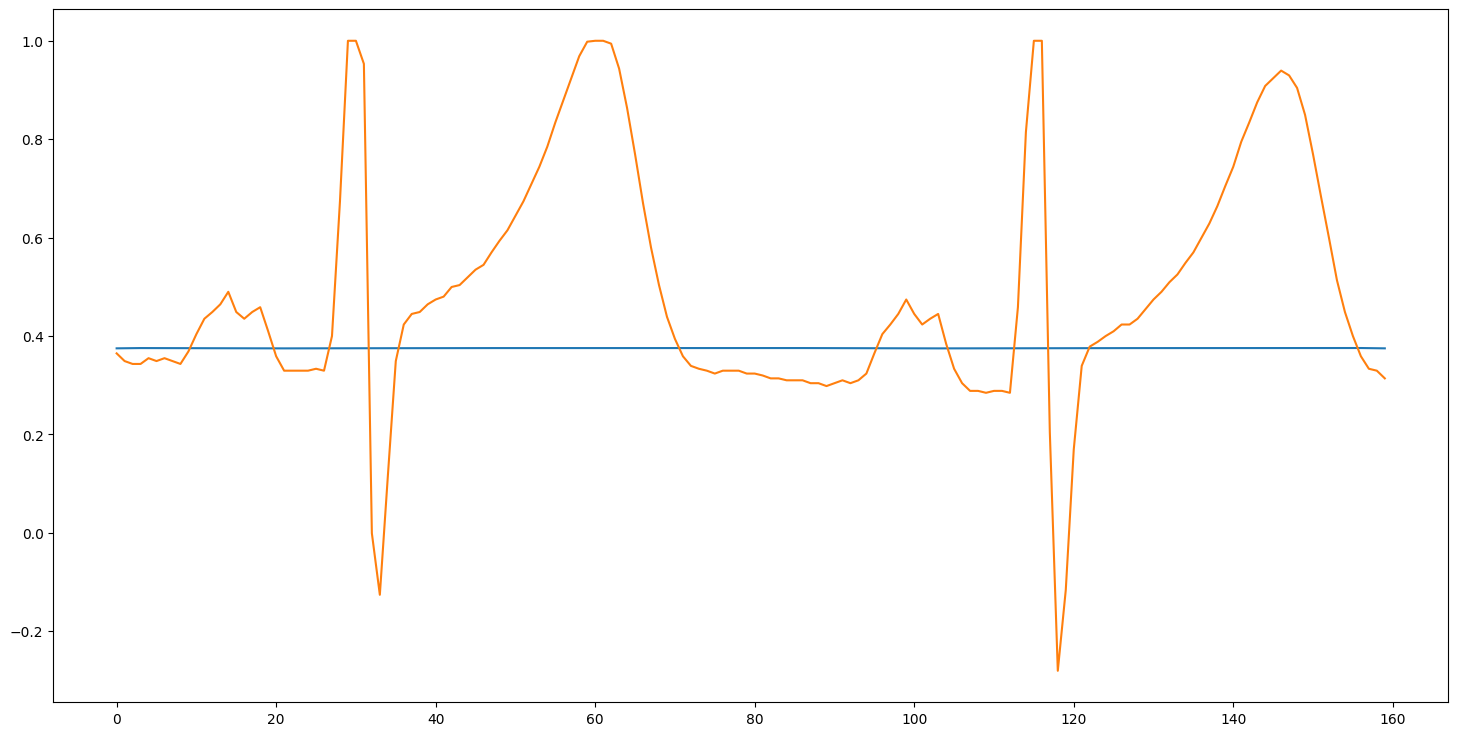

In [97]:
num_epochs = 1000

window_size = 160

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

generator = GAN_Generator().to(device)
discriminator = GAN_Discriminator().to(device)
generator = generator.to(torch.float32).to(device)
discriminator = discriminator.to(torch.float32).to(device)
dataset = PPG2ECGDataset(PPG[:50000], ECG[:50000])
dataloader = DataLoader(dataset, batch_size=512)


# criterion = nn.MSELoss()
adversarial_loss = nn.BCELoss()
# lr = 10e-4
optimizer_G = optim.Adam(generator.parameters(), weight_decay=0.2)
optimizer_D = optim.Adam(discriminator.parameters(), weight_decay=0.2)

# schedular_G = optim.lr_schedular.StepLR(optimizer_G, step_size=10, gamma=0.1)
# schedular_D = optim.lr_schedular.StepLR(optimizer_D, step_size=10, gamma=0.1)

train_log = []

generator.train()
discriminator.train()
for epoch in range(num_epochs):
    # running_loss = 0
    for real_ppg, tgt, real_ecg in tqdm(dataloader):
        real_ppg = real_ppg.unsqueeze(1).to(device)
        real_ecg = real_ecg.unsqueeze(1).to(device)

        batch_size = real_ppg.shape[0]
        # print(batch_size)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train discriminator real
        optimizer_D.zero_grad()
        pred_real = discriminator(real_ecg, real_ppg)
        d_loss_real = adversarial_loss(pred_real, real_labels)
        # d_loss_real.backward()

        # Train discriminator fake
        fake_ecg = generator(real_ppg)
        pred_fake = discriminator(fake_ecg, real_ppg)
        d_loss_fake = adversarial_loss(pred_fake, fake_labels)
        # d_loss_fake.backward()

        d_loss = (d_loss_real + d_loss_fake) * 10 ## Update!!
        d_loss += calculate_wa_loss(discriminator, real_ecg, fake_ecg, real_ppg)
        d_loss.backward()
        optimizer_D.step()
        
        # Train generator
        optimizer_G.zero_grad()
        fake_ecg = generator(real_ppg)
        pred_fake = discriminator(fake_ecg, real_ppg)
        g_loss = adversarial_loss(pred_fake, real_labels)
        # peak_loss = get_peak_loss(fake_ecg, real_ecg)
        peak_loss = peak_alignment_loss(fake_ecg, real_ecg, height=0.3, distance=10)
        g_loss += combined_loss(fake_ecg, real_ecg)
        g_loss += peak_loss
        
        
        g_loss.backward()

        optimizer_G.step()

    # schedular_D.step()
    # schedular_G.step()
    print(f"Epoch {epoch}, d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")
    # train_log.append(running_loss / len(dataset))
    
    torch.save(generator.state_dict(), f"gan_generator_att_peakalign_03_10.pth")
    torch.save(discriminator.state_dict(), f"gan_discriminator_att_peakalign_03_10.pth")

with open(f"train_loss_gan_att_peakalign_03_10.pkl", "wb") as f:
    pickle.dump(train_log, f)
    # torch.save(generator.state_dict(), f"gan_generator_att_peakalign_03_10.pth")
    # torch.save(discriminator.state_dict(), f"gan_discriminator_att_peakalign_03_10.pth")

# Test 
test_dataset = PPG2ECGDataset(PPG[50001:51000], ECG[50001:51000])
test_dataloader = DataLoader(test_dataset, batch_size=1)
# generator = GAN_Generator()
# generator = generator.to(torch.float32)
# generator.load_state_dict(torch.load("gan_generator_bceloss.pth", weights_only=True))
# criterion = nn.MSELoss()

test_log = []
out_lst = []
target_lst = []
device = "cpu"
generator.to(device)

for src, tgt, target in tqdm(test_dataloader):
    src = src.unsqueeze(1).to(device)
    # tgt = tgt.to(device)
    target = target.unsqueeze(1)
    target = target.to(device)
    out = generator(src)
    out = out.to(device)
    out_lst.append(out)
    target_lst.append(target)
    # loss = criterion(out, target)
    loss = combined_loss(out, target)
    test_log.append(loss.item())


out_lst_cpu = np.array([o.detach().to("cpu") for o in out_lst]).squeeze()
target_lst_cpu = np.array([t.detach().to("cpu") for t in target_lst]).squeeze()
# print(out_lst_cpu.shape)
# print(target_lst_cpu.shape)
plt.figure(figsize=(18, 9))

plt.plot(out_lst_cpu[0])
plt.plot(target_lst_cpu[0])

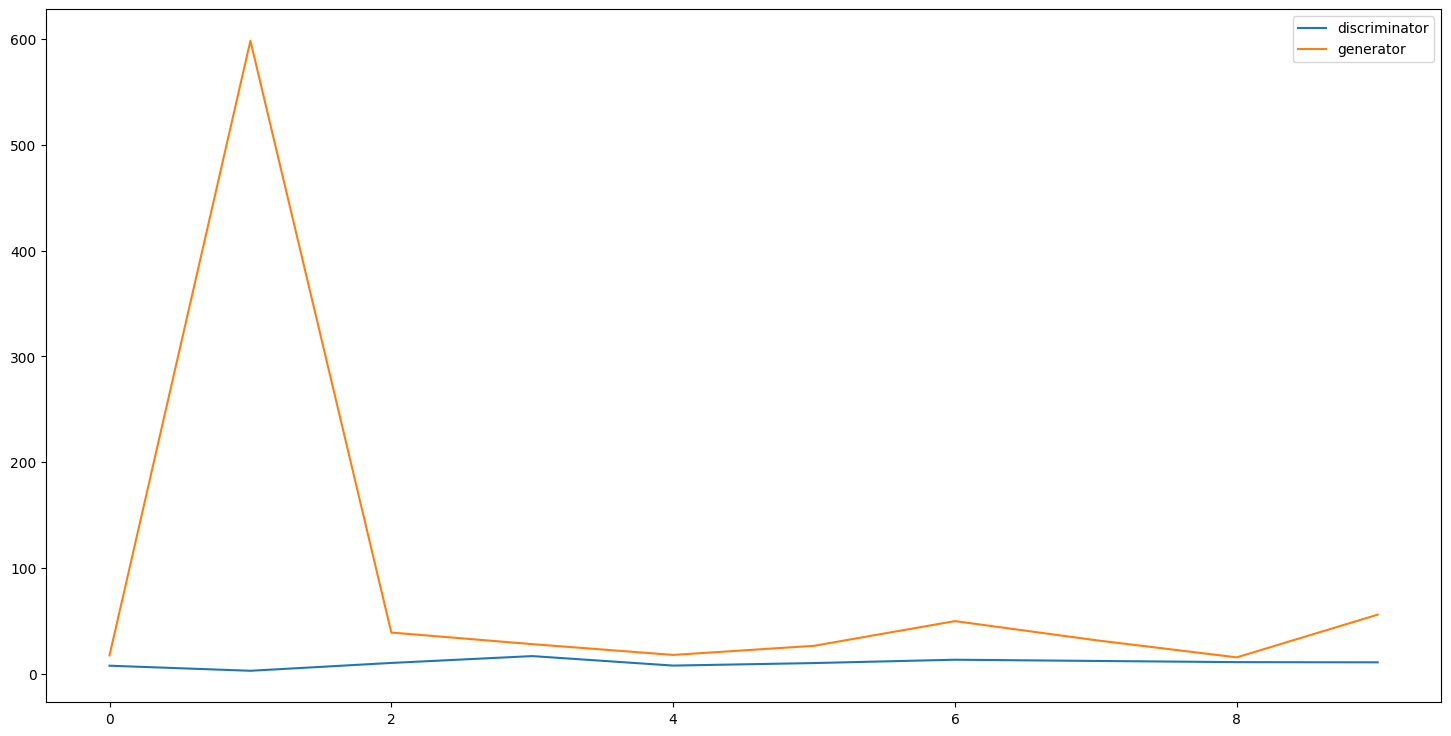

In [17]:
plt.figure(figsize=(18, 9))

plt.plot(gan_t_loss[-20::2], label="discriminator")
plt.plot(gan_t_loss[-19::2], label="generator")
plt.legend()